In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [72]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated_avg")
df=data_df.loc[15:,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd","churn","temp_deviation","price_range","price_gas_avg", "price_brent_usd","storage_dev","usd_gbp","share_lng","price_gas_ma","price_gas_ma_avg"]] 
print(df)


#start at 15 for churn
#first ets value at line 38

     months   price_gas  price_brent_gbp  open_interest_gas       lng  \
15   Jan 11   61.175612        66.785907             28.710  2.430000   
16   Feb 11   58.253804        70.022260             22.565  1.990000   
17   Mar 11   65.671980        77.353399             19.575  2.460000   
18   Apr 11   63.693670        79.431267             16.590  2.680000   
19   May 11   61.265423        74.670881             19.680  2.480000   
..      ...         ...              ...                ...       ...   
145  Nov 21  183.586741        53.162419             45.540  1.387771   
146  Dec 21  251.302819        47.738814             45.135  2.011959   
147  Jan 22  178.944299        56.173519             37.335  3.146688   
148  Feb 22  169.752159        62.720169             33.040  2.051291   
149  Mar 22  266.303049        76.207482             25.101  2.154597   

      storage  temperature      euas     supply    coal_gbp  ...  churn  \
15   0.450000         5.10   17.7055  10.150000 

In [73]:
#Vector:
dprice_gas=df.price_gas
dprice_gas_avg=df.price_gas_avg
dprice_gas_ma_avg=df.price_gas_ma_avg
dprice_gas_ma=df.price_gas_ma
dprice_brent_gbp=df.price_brent_gbp
dprice_brent_usd=df.price_brent_usd
dOI=df.open_interest_gas
dtemp=df.temperature
dtempdev=df.temp_deviation
dstore=df.storage
dlng=df.lng
dshare_lng=df.share_lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dGBPUSD=df.gbpusd
dcoal=df.coal_gbp
dchurn=df.churn
drange=df.price_range
dstore_dev=df.storage_dev
dUSDGBP=df.usd_gbp


time= df.months
DataSeries=[dtempdev, dprice_brent_usd, dGBPUSD, dstore_dev, dshare_lng, dchurn, dprice_gas]
price_gas_typo = 'price_gas'
lng_typo = 'share_lng'

#DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp, dtempdev]

#DataSeries=[dprice_gas,dprice_brent_gbp,dOI,dstore,dlng,dtemp,dsupply,dEUAs,dchurn,dtempdev,dEUR,dUSD,dcoal]
df_test = pd.concat(DataSeries,axis=1)

In [74]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


In [75]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

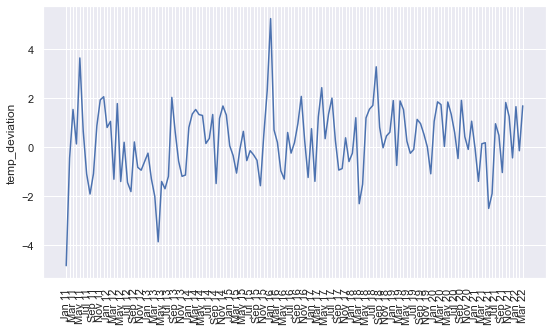

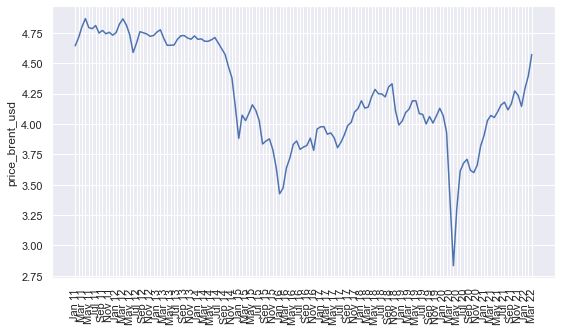

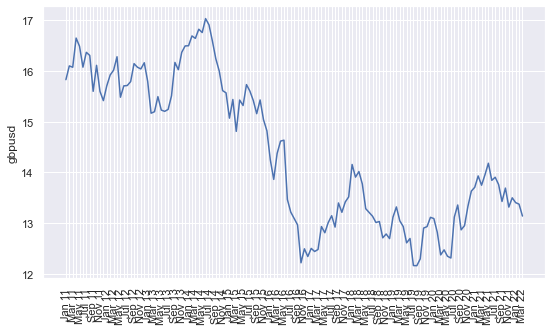

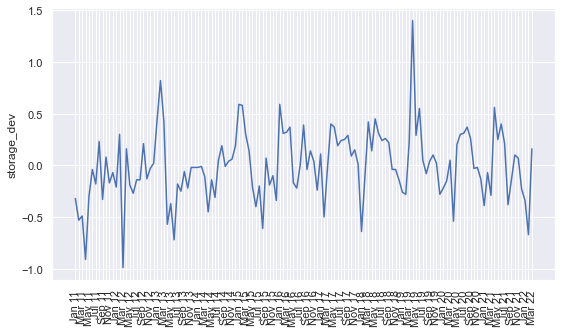

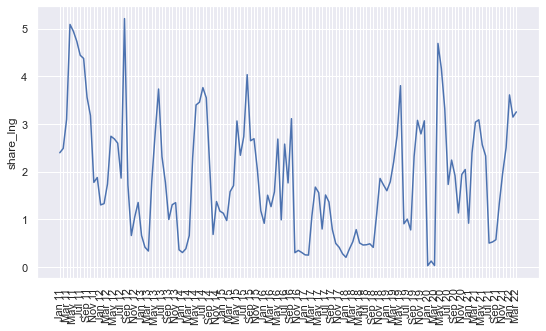

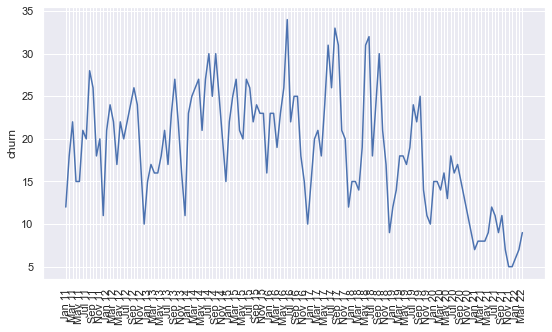

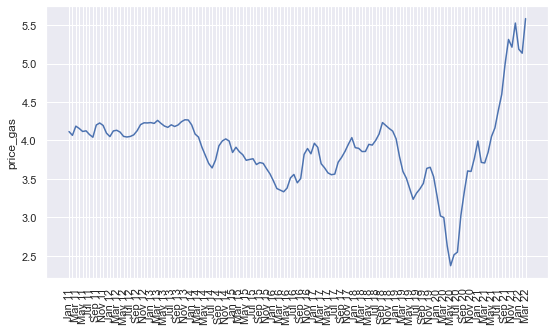

In [76]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

from statistics import mean
#### initiate corrected series
DataSeriesCorr=[]

#### select correction mode
TypeCorr = 'mixed' # 'HP' for filtering or 'log' or 'bothHPlog'

HP = [] #['churn'],['churn','usd_gbp']
loga = ['price_brent_usd','price_gas_avg','price_gas','price_gas_ma','price_gas_ma_avg']
#demean = loga

for df in DataSeries:

    if TypeCorr == "log" or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
            if df.name in loga:
                df_log = pd.Series(np.log(df))
                df = df_log

    if TypeCorr == 'HP' or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
        if df.name in HP or TypeCorr == 'HP':
            cycle, trend = sm.tsa.filters.hpfilter(df, 129600)
            plt.plot(trend)
            plt.plot(cycle)
            cycle.name = df.name
            #trans = cycle/trend
            #plt.plot(trans)
            #trans.name = df.name
            df = cycle

    #if TypeCorr == "log" or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
        #if df.name in demean:
            #df_mean = pd.Series(df-mean(df))
            #df = df_mean


    if TypeCorr == 'diff':
        df_diff = df.diff().dropna()
        df = df_diff

    plt.figure(figsize=(9, 5))
    if TypeCorr == 'diff':        
        plt.plot(time.iloc[1:], df)
    else: 
        plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)

df_corr = pd.concat(DataSeriesCorr,axis=1)

TRUNCATE DATASET

In [77]:
start=15
end=50

##### periods considered : 15 - 50 ; 50 - 105 ; 105 - 149
df_correction = df_corr.loc[:,:]
print(df_correction)
df_corr = df_corr.loc[15:140,:]
print(df_corr)

     temp_deviation  price_brent_usd    gbpusd  storage_dev  share_lng  churn  \
15        -4.838333         4.643241  15.82930        -0.32   2.394089   12.0   
16        -0.440000         4.710267  16.10047        -0.53   2.484395   18.0   
17         1.546667         4.800665  16.07407        -0.49   3.094340   22.0   
18         0.138333         4.866745  16.65002        -0.91   5.085389   15.0   
19         3.653333         4.792601  16.48777        -0.30   4.940239   15.0   
..              ...              ...       ...          ...        ...    ...   
145        1.265000         4.235764  13.31505         0.07   1.973155    5.0   
146       -0.431667         4.143990  13.49837        -0.23   2.502431    5.0   
147        1.661667         4.289511  13.40339        -0.34   3.607525    6.0   
148       -0.140000         4.396208  13.37327        -0.67   3.142185    7.0   
149        1.696667         4.571204  13.13888         0.16   3.250823    9.0   

     price_gas  
15    4.11

In [78]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


In [79]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

In [80]:
#### EXPORT NORMALISED DATA ####


df_export = df_corr

#df_export.insert(0,'months',time)
#print(df_export)
#df_export.to_excel(r'export_normal_data.xlsx', index = False)

#df_corr.drop(columns=['months'])
#print(df_corr)

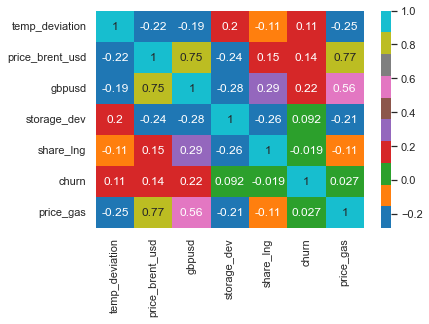

In [81]:
#### CORRELATION MATRIX ####

CorrelationMatrix=df_corr.corr()
ax=sns.heatmap(CorrelationMatrix, annot=True, cmap="tab10")


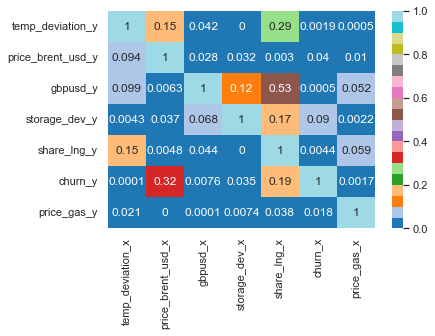

In [82]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
#print(df_corr)
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


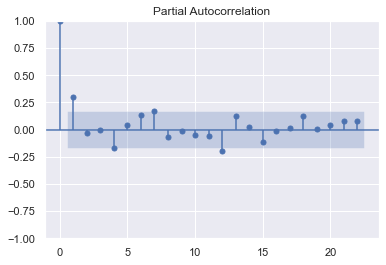

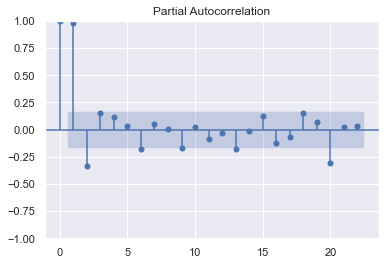

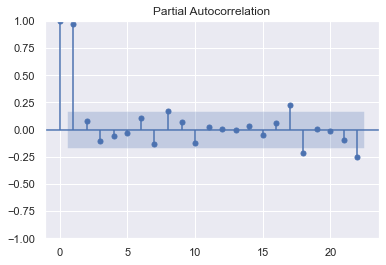

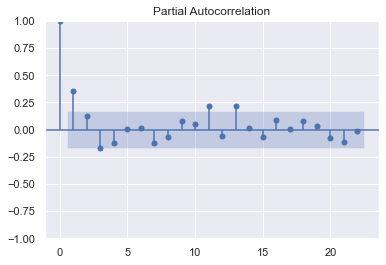

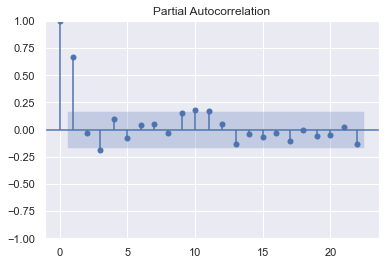

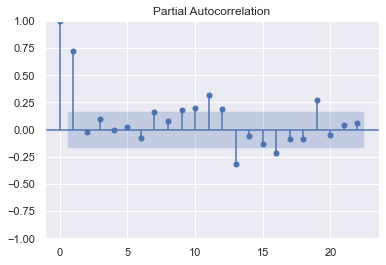

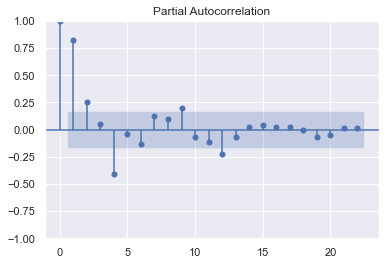

In [83]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [84]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


<class 'statsmodels.iolib.table.SimpleTable'>

In [85]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(6)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Aug, 2022
Time:                     18:44:02
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -2.49675
Nobs:                     120.000    HQIC:                  -6.64925
Log likelihood:          -321.586    FPE:                9.55591e-05
AIC:                     -9.48871    Det(Omega_mle):     1.12002e-05
--------------------------------------------------------------------
Results for equation temp_deviation
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      4.317932         1.724649            2.504           0.012
L1.temp_deviation          0.374094         0.116678            3.206           0.001
L1.price_brent_usd         0.90

True


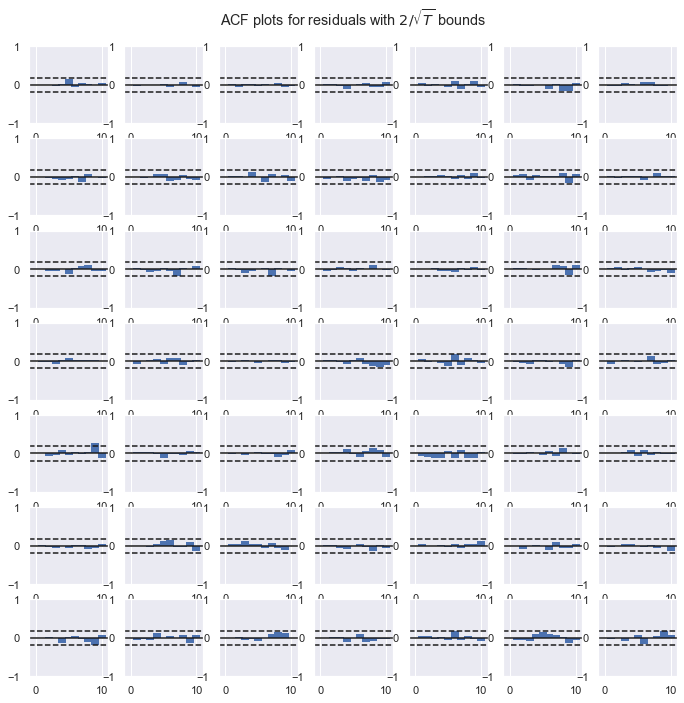

In [86]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
accor = model_fit.plot_acorr()

stab = model_fit.is_stable()
print(stab)

#if residuals out of range -> unstable model 

In [87]:
######### GRANGER CAUSALITY TEST #########
#for gas price
#GrangerCausality = model_fit.test_causality('price_gas', ['lng'], kind='f')
#print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

In [88]:
######### NORMALITY TEST #########

TestNorm = model_fit.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         20.23          23.68   0.123 14
----------------------------------------


In [89]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = model_fit.test_whiteness(nlags=18)
print(TestWhite.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 18 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         642.6          645.5   0.059 588
-----------------------------------------


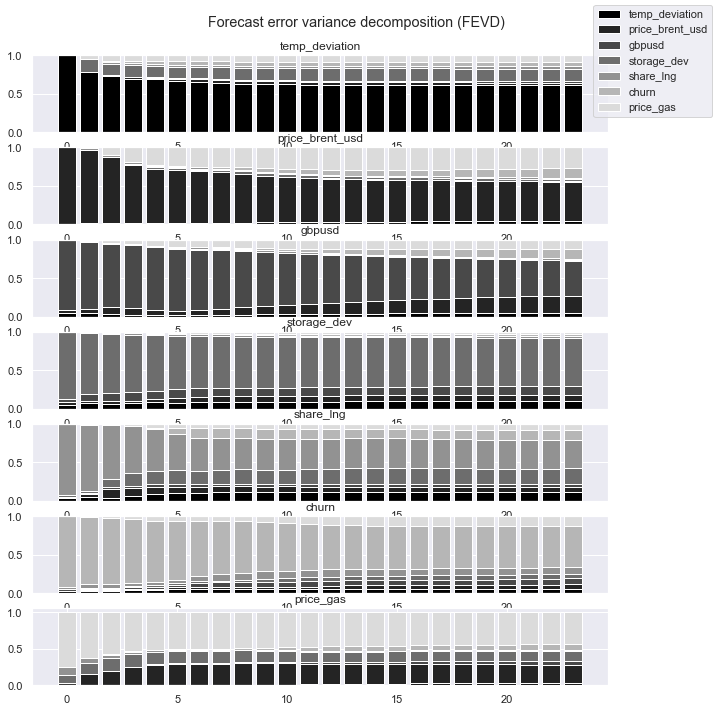

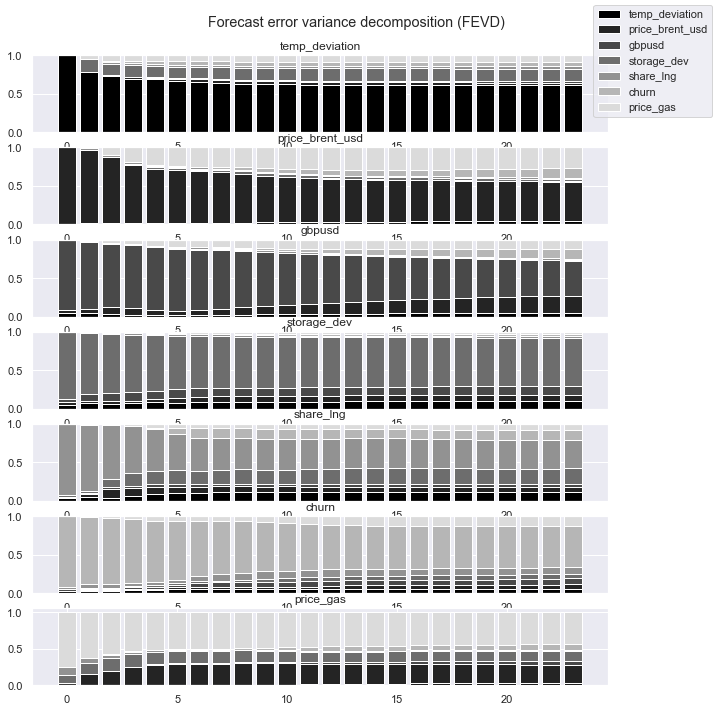

In [90]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=24
VD = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
VD.plot()

IMPULSE RESPONSE ANALYSIS:

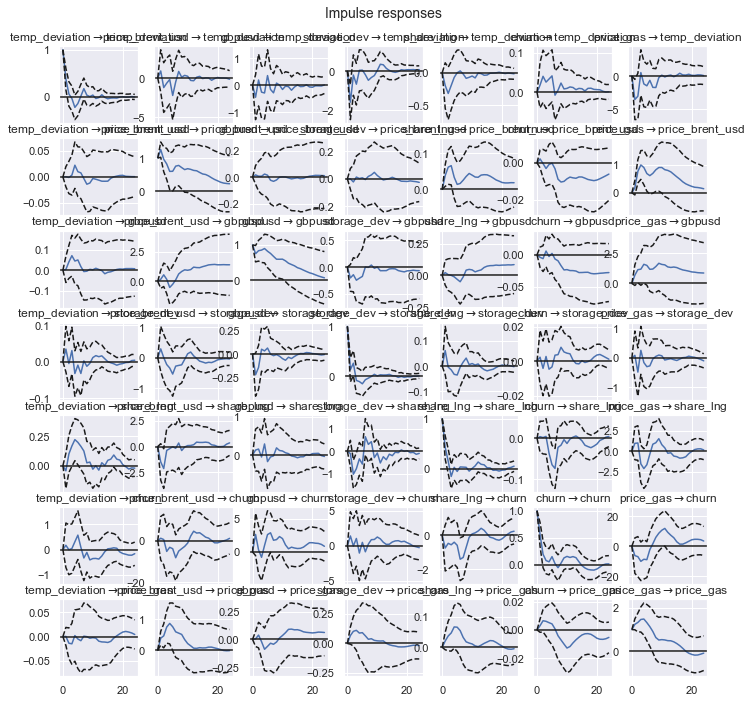

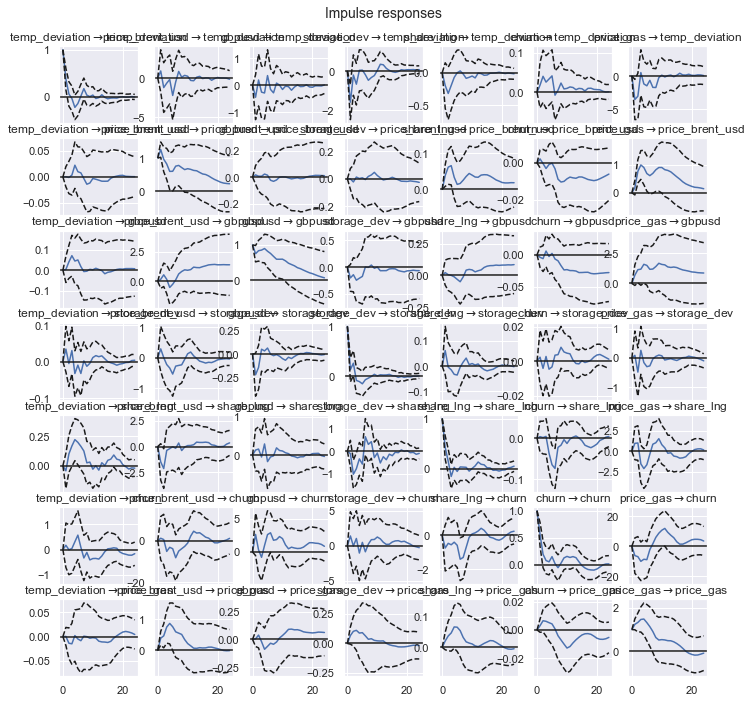

In [91]:
Impulse = model_fit.irf(24)

Impulse.plot()

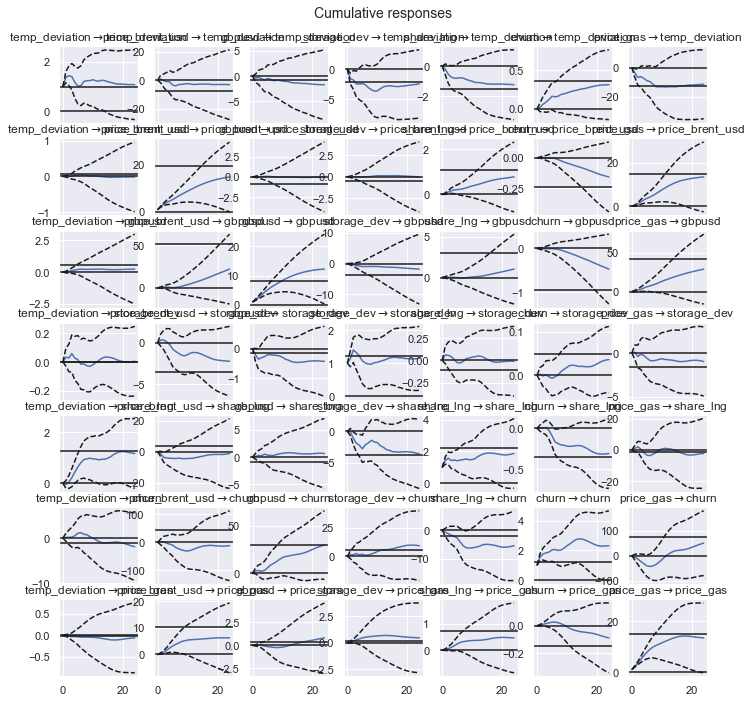

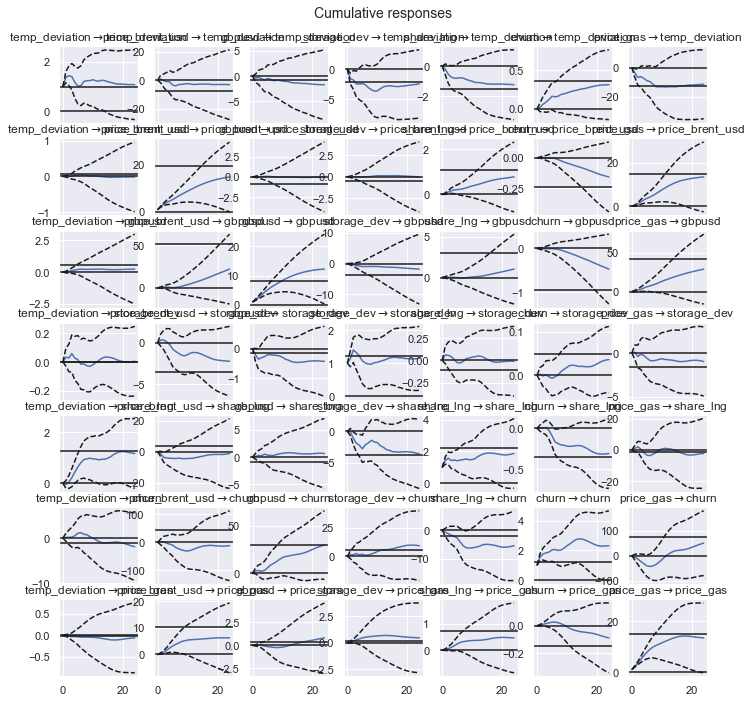

In [92]:
Impulse.plot_cum_effects(orth=False)

OTHER MODELS

In [193]:
from statsmodels.tsa.api import SVAR

###### dataset used ######
start=15
end=80

print(data_df.loc[76])
print(data_df.loc[149])
##### periods considered : 15 - 50 ; 50 - 105 ; 105 - 149
df_corr = df_correction.loc[start:end,:]
#print(df_corr)

lag_order = 5

#A = np.asarray([['E',0,0,0,0,0,0], [0,'E','E',0,0,0,0],[0,'E','E',0,0,0,0],['E',0,0,'E','E',0,'E'],['E',0,'E','E','E',0,'E'],['E','E','E','E','E','E','E'],['E','E','E','E','E',0,'E']])
#A = np.asarray([['E', 0, 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0, 0],[0, 0, 0, 'E', 0, 0, 'E'],[0, 0, 0, 0, 'E', 0, 'E'],['E', 'E', 'E', 'E', 'E', 'E', 'E'],['E', 'E', 'E', 'E', 'E', 0, 'E']])
A = np.asarray([['E', 0, 0, 0, 0, 0, 0], ['E', 'E', 0, 0, 0, 0, 0],[0, 'E', 'E', 0, 0, 0, 0],['E', 'E', 0, 'E', 0, 0, 'E'],['E', 'E', 0, 'E', 'E', 0, 'E'],['E', 'E', 'E', 'E', 'E', 'E', 0],['E', 'E', 'E', 'E', 'E', 'E', 'E']])
#A = np.asarray([['E', 0, 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0, 0],[0, 0, 0, 'E', 0, 0, 0],[0, 0, 0, 0, 'E', 0, 0],[0, 0, 0, 0, 0, 'E', 0],['E', 'E', 'E', 'E', 'E', 'E', 'E']]) 

StructModel = SVAR(df_corr,svar_type='A', A=A)
#dtempdev, dstore, dlng, dprice_brent_gbp, drange

ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=100000, maxfun=100000, solver='bfgs')


months                  Feb 16
price_gas            29.155454
price_brent_gbp      23.261166
open_interest_gas        61.84
temperature               6.15
lng                        1.2
storage                   1.04
euas                   22.3215
supply                    7.98
coal_gbp             32.022053
eurgbp                 0.77345
gbpusd                13.86194
cpi_uk                    99.8
churn                     23.0
temp_deviation            0.71
price_range           6.461115
price_gas_avg_raw    29.097143
price_gas_avg        29.155454
price_brent_usd      32.167243
cpi_us               100.03966
storage_dev               0.31
usd_gbp               7.213997
share_lng             1.503759
price_gas_ma         30.260521
price_gas_ma_avg     29.239908
Name: 76, dtype: object
months                   Mar 22
price_gas            266.303049
price_brent_gbp       76.207482
open_interest_gas        25.101
temperature                9.05
lng                    2.154597
storage  

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [194]:
##### IS STABLE ? #####
Stab = ResSVAR.is_stable()
print("SVAR model is stable ? :   ",Stab)


SVAR model is stable ? :    False


In [195]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

#TestWhite = ResSVAR.test_whiteness(nlags=12)
#print(TestWhite.summary())

TestWhite = ResSVAR.test_whiteness(nlags=24)
print(TestWhite.summary())  

#Portmanteau test

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 24 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         963.1          1003.   0.226 931
-----------------------------------------


In [196]:
######### NORMALITY TEST #########

TestNorm = ResSVAR.test_normality(signif=0.05)
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         15.36          23.68   0.354 14
----------------------------------------


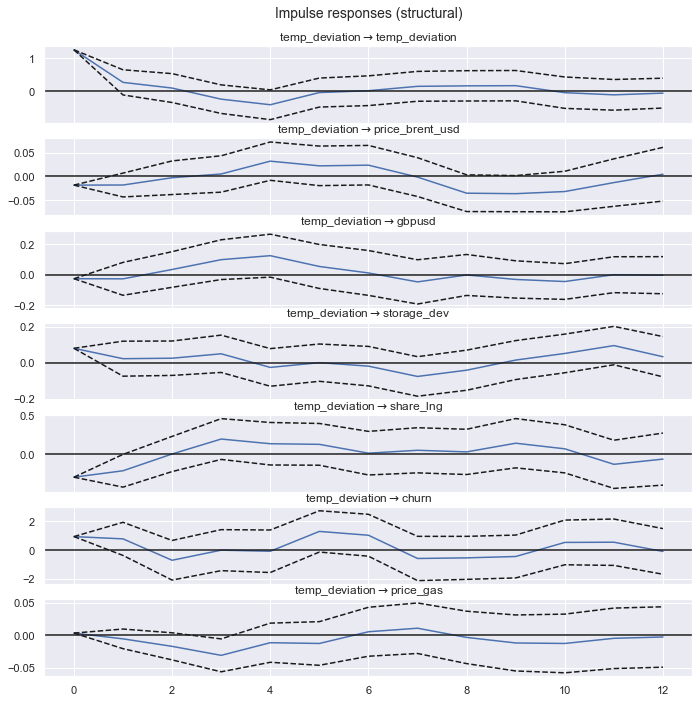

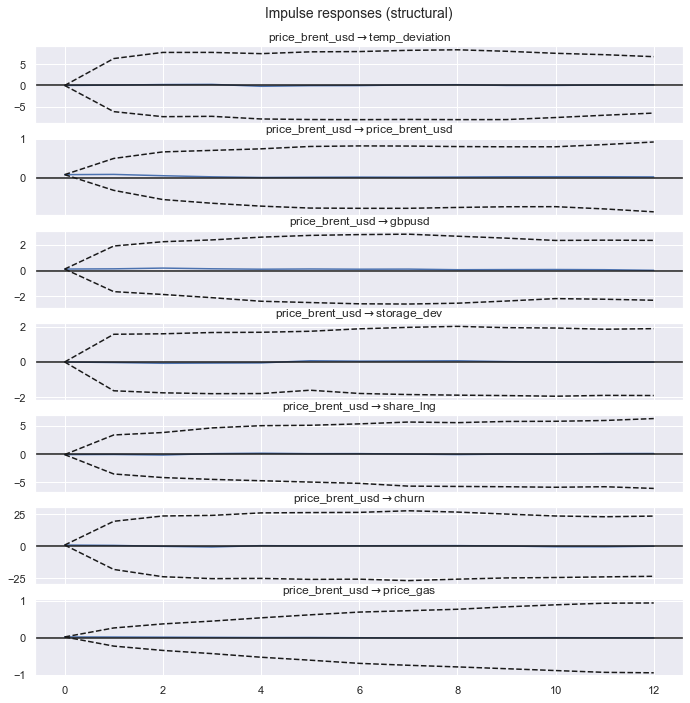

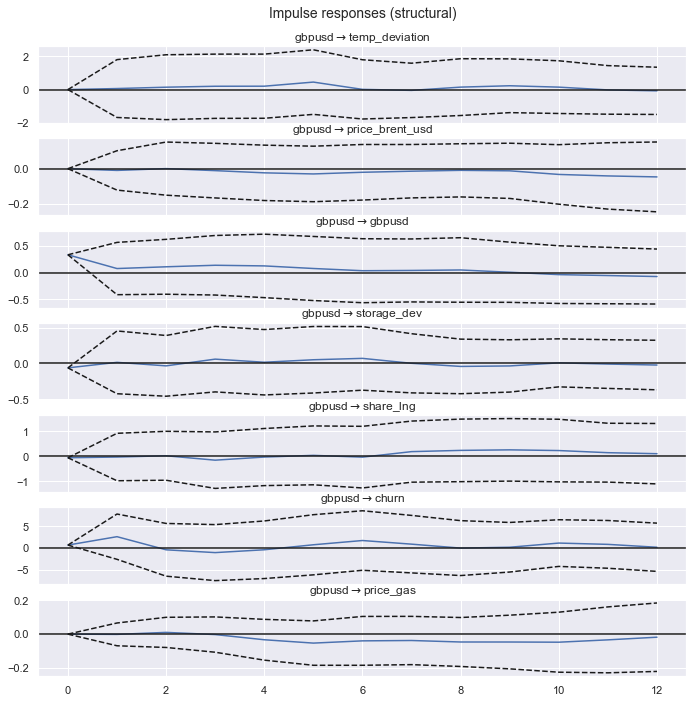

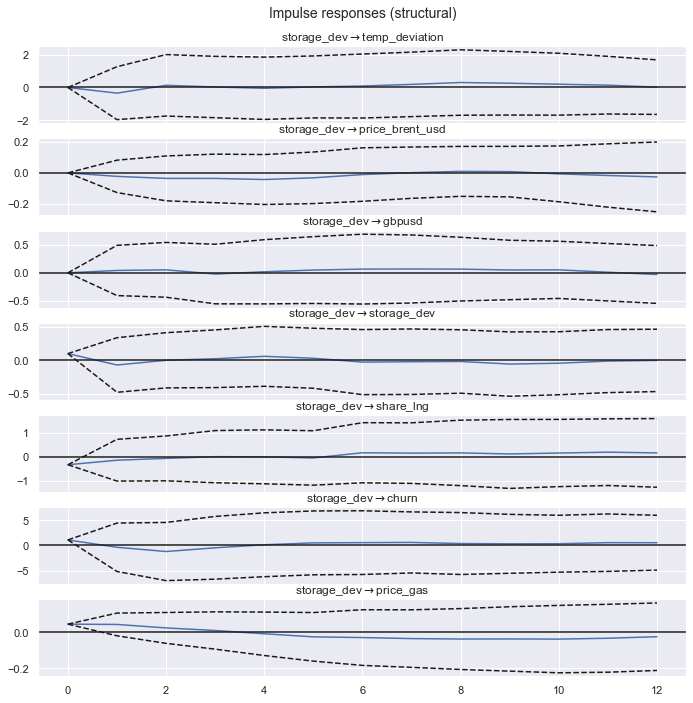

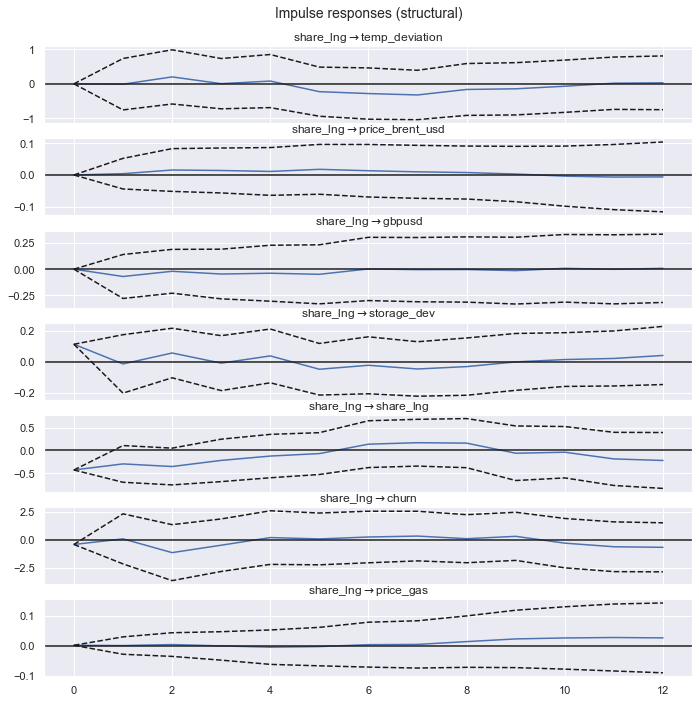

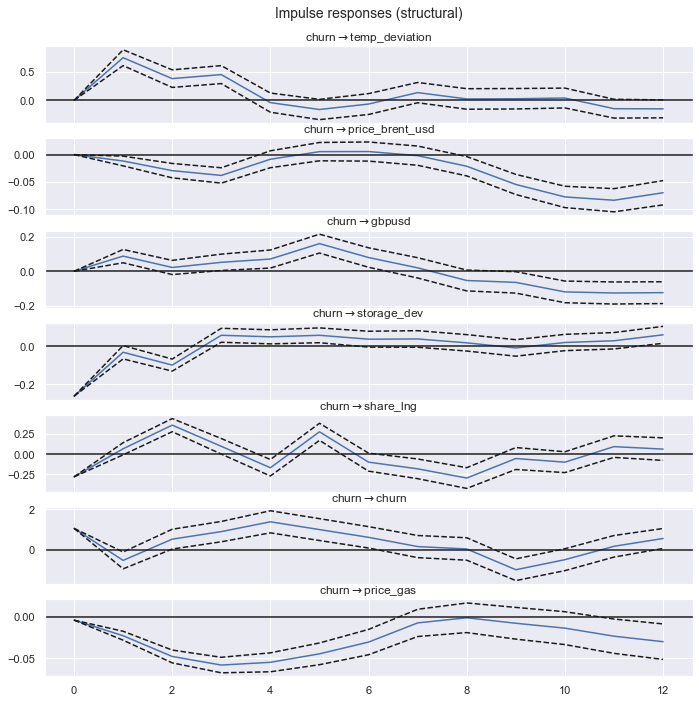

Error in callback <function flush_figures at 0x2814269d0> (for post_execute):


KeyboardInterrupt: 

In [197]:
#### IR ####


ResSVAR.irf(periods=12).plot(impulse='temp_deviation')
ResSVAR.irf(periods=12).plot(impulse='price_brent_usd')
ResSVAR.irf(periods=12).plot(impulse='gbpusd')
ResSVAR.irf(periods=12).plot(impulse='storage_dev')
ResSVAR.irf(periods=12).plot(impulse=lng_typo)
ResSVAR.irf(periods=12).plot(impulse='churn')
#ResSVAR.irf(periods=12).plot(impulse='price_gas_avg')
ResSVAR.irf(periods=12).plot(impulse=price_gas_typo)


ResSVAR.irf()


#ResSVAR.irf(periods=12).plot(impulse='price_gas_avg', plot_stderr=True,stderr_type='asym', repl=100)



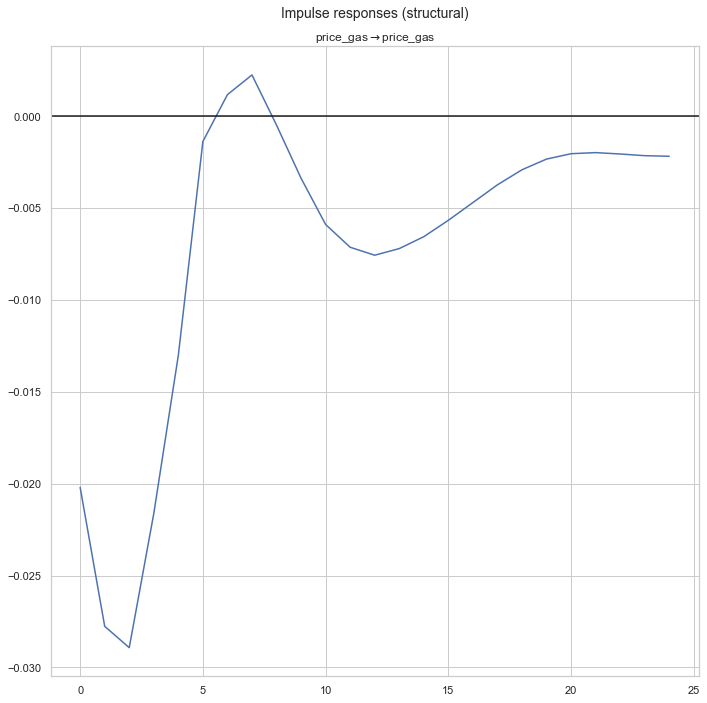

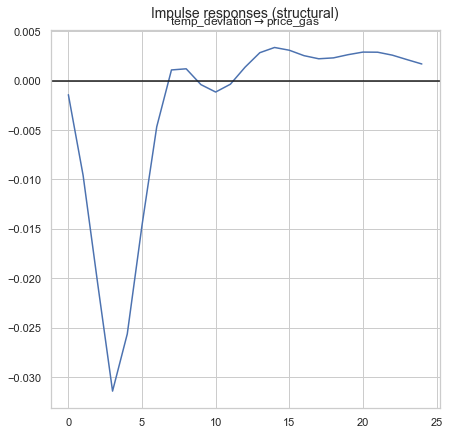

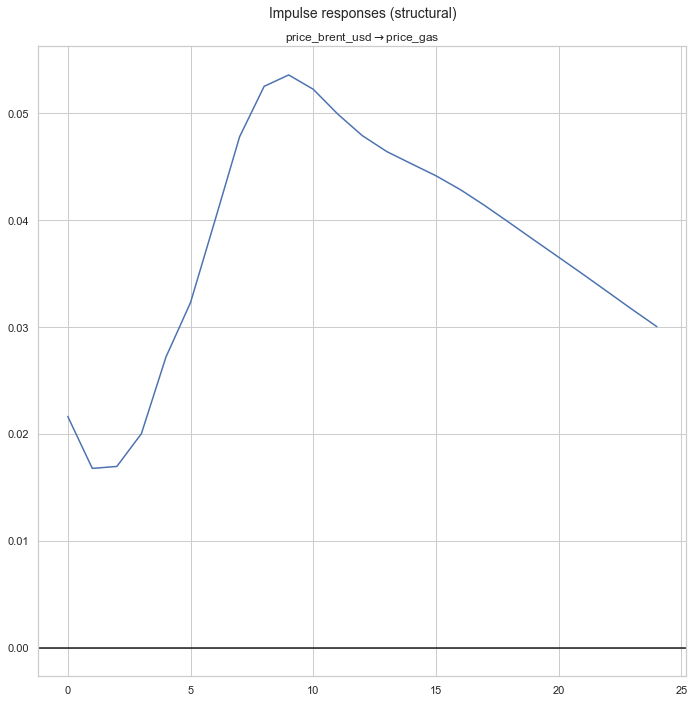

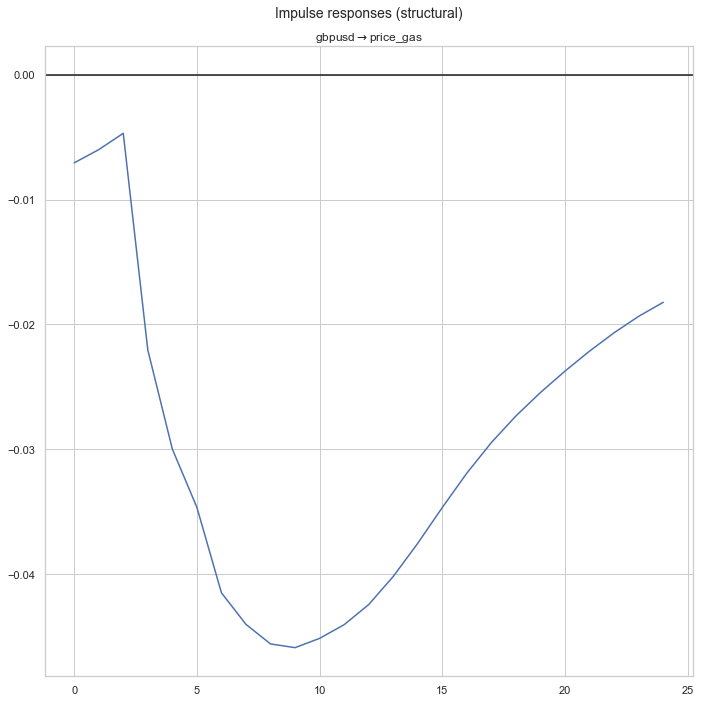

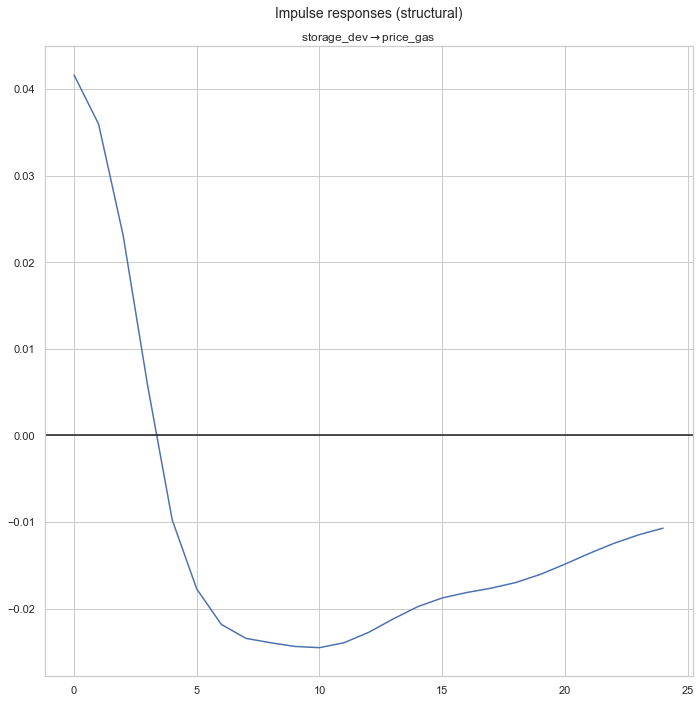

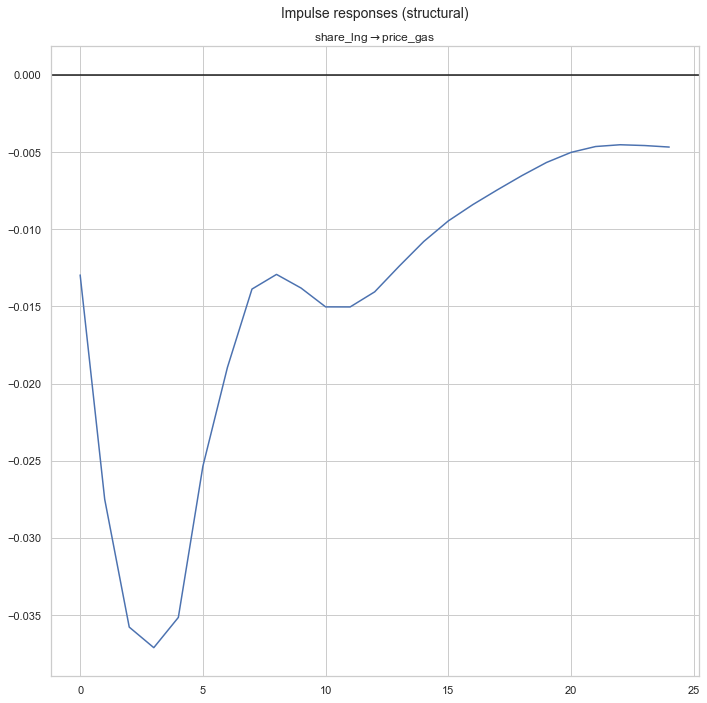

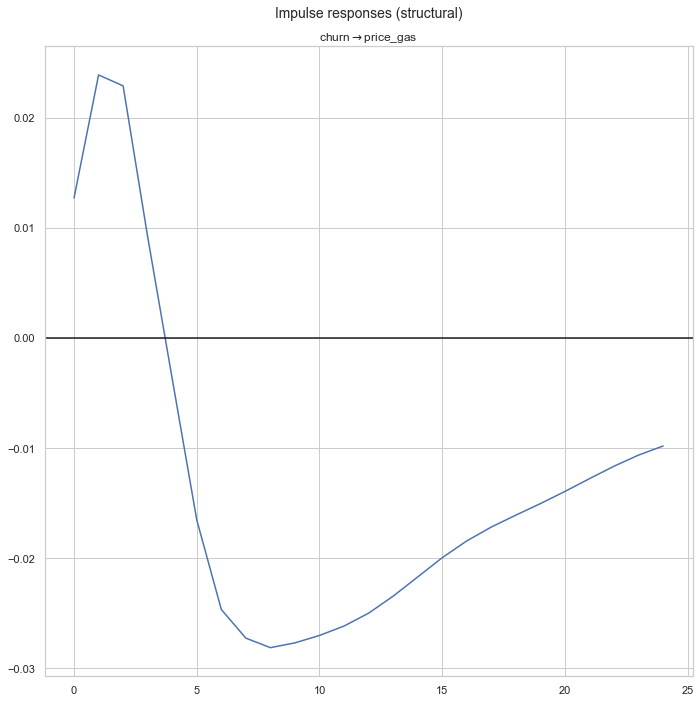

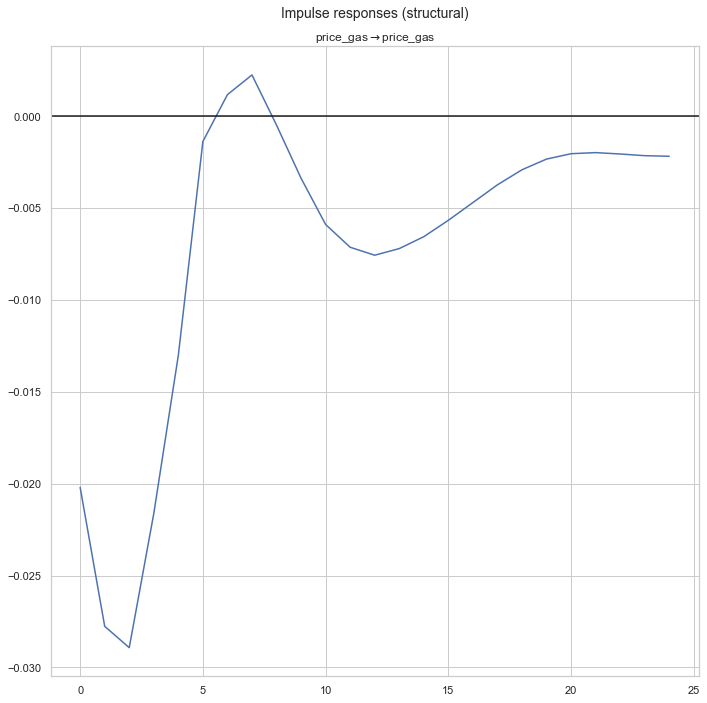

In [ ]:
### IR ###

Periods=24
Reps=500
ERRORTYPE = 'asym'
FIGsize=[6,6]

plotstderr=False
ResSVAR.irf(periods=Periods).plot(impulse='temp_deviation', response=price_gas_typo, plot_stderr=plotstderr,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse='price_brent_usd', response=price_gas_typo, plot_stderr=plotstderr,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='gbpusd', response=price_gas_typo, plot_stderr=plotstderr,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='storage_dev', response=price_gas_typo, plot_stderr=plotstderr,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse=lng_typo, response=price_gas_typo, plot_stderr=plotstderr,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse='churn', response=price_gas_typo, plot_stderr=plotstderr,stderr_type=ERRORTYPE, repl=Reps)
ResSVAR.irf(periods=Periods).plot(impulse=price_gas_typo, response=price_gas_typo, plot_stderr=plotstderr,stderr_type=ERRORTYPE, repl=Reps)


ALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL BELOW


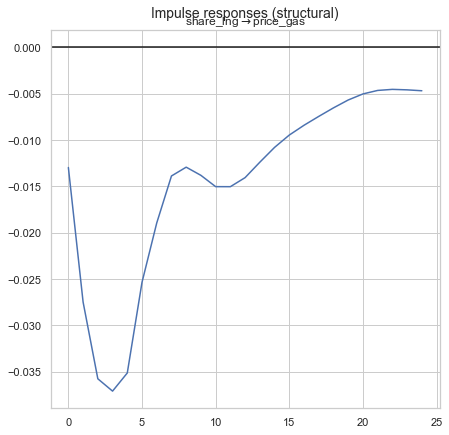

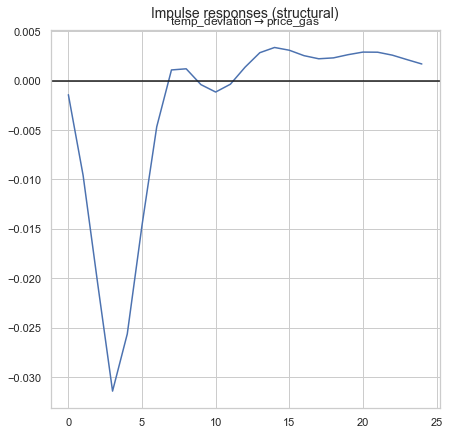

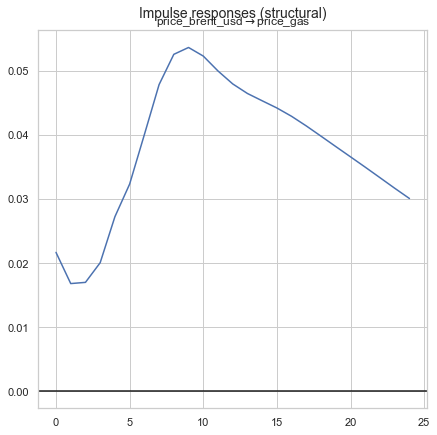

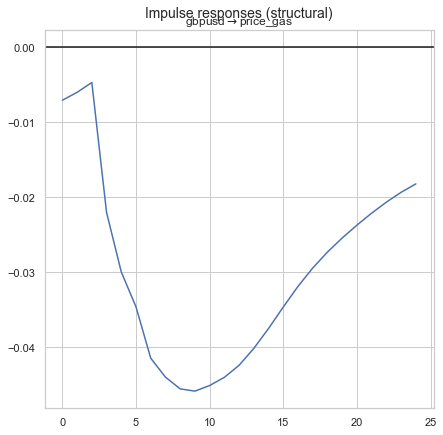

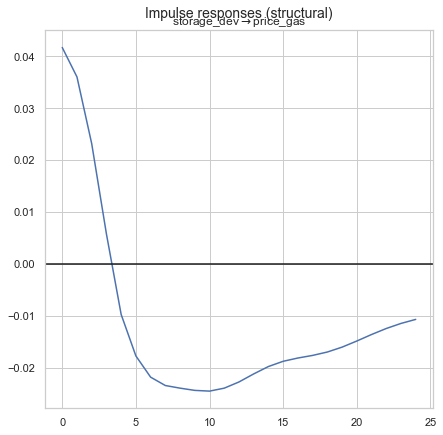

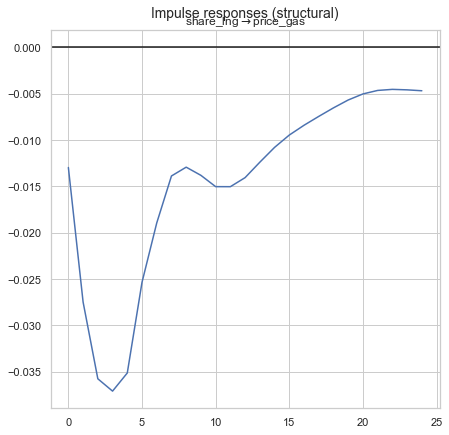

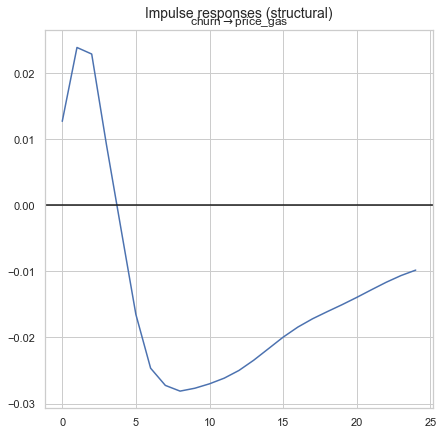

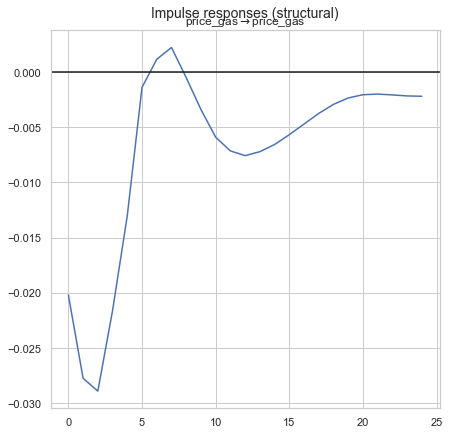

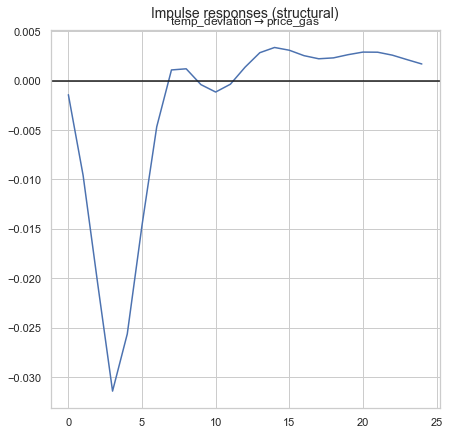

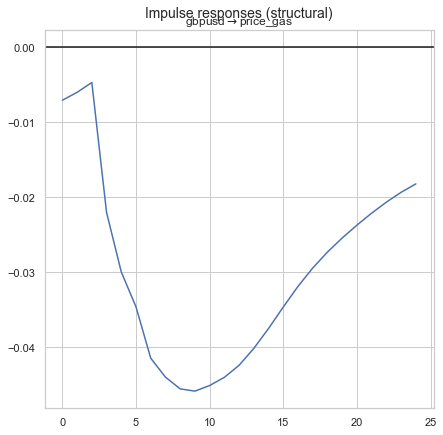

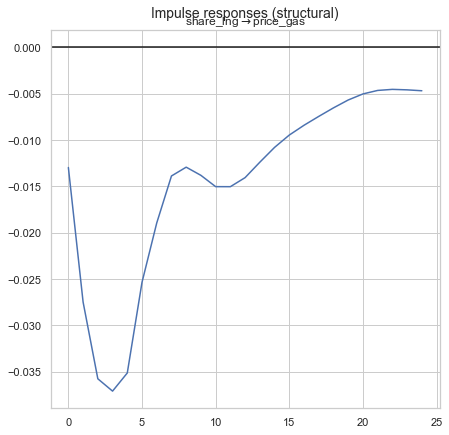

In [ ]:

indexes= ['temp_deviation', 'price_brent_usd', 'gbpusd', 'storage_dev', lng_typo, 'churn', price_gas_typo]
#               0                   1              2           3          4        5           6

sns.set_theme(style="whitegrid")


imp=2
resp=6

Reps = 50
ERRORTYPE = 'mc'
FIGsize=[6,6]
plot_errband=False
Cum=True

#ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=price_gas_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=price_gas_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=price_gas_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=price_gas_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=price_gas_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=price_gas_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=price_gas_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)



print('ALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL BELOW')

# ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

# ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

# ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

# ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

# ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

# ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

# ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
# ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)



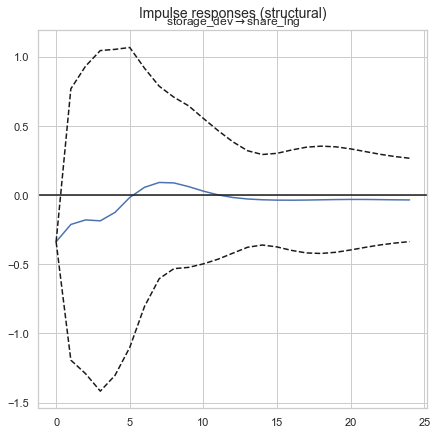

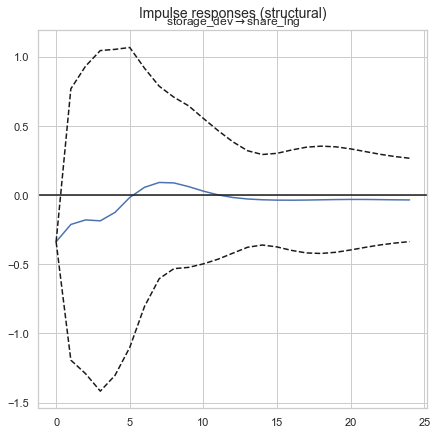

In [ ]:
Reps = 500
ERRORTYPE = 'asym'
FIGsize=[6,6]
plot_errband=True

ResSVAR.irf(periods=Periods).plot(impulse='storage_dev', response=lng_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=lng_typo, response='storage_dev', plot_stderr=lng_typo,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=price_gas_typo, response=lng_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse=price_gas_typo, response='churn', plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

#ResSVAR.irf(periods=Periods).plot(impulse='gbpusd', response=lng_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse='price_brent_usd', response=lng_typo, plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse='storage_dev', response='churn', plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
#ResSVAR.irf(periods=Periods).plot(impulse='temp_deviation', response='churn', plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/vector_ar/plotting.py:208: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True,


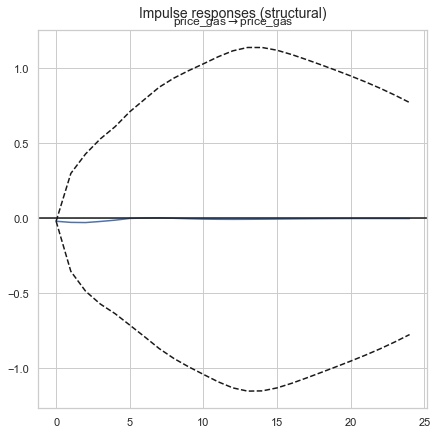

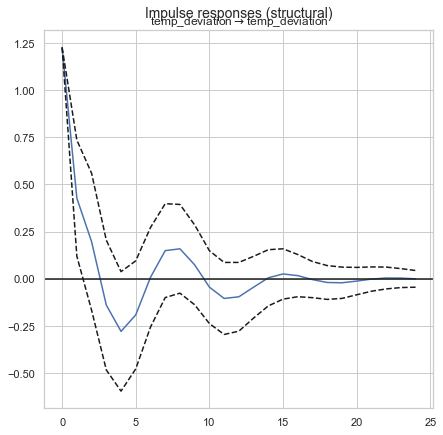

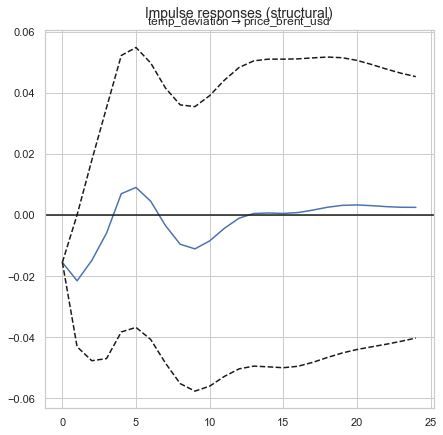

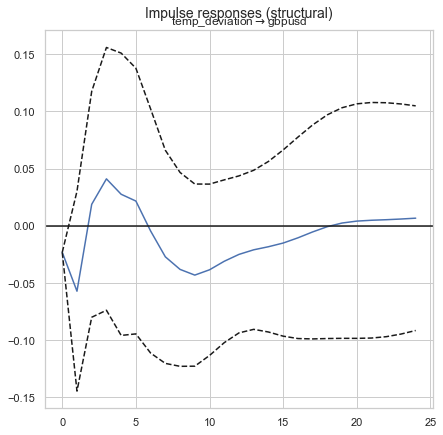

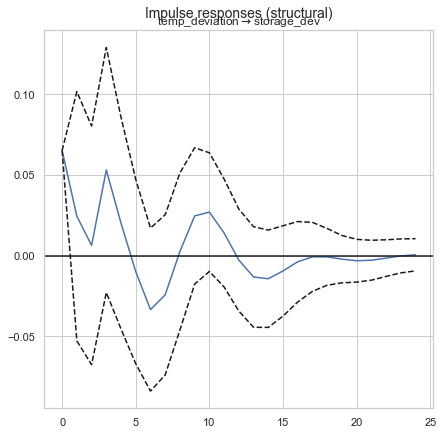

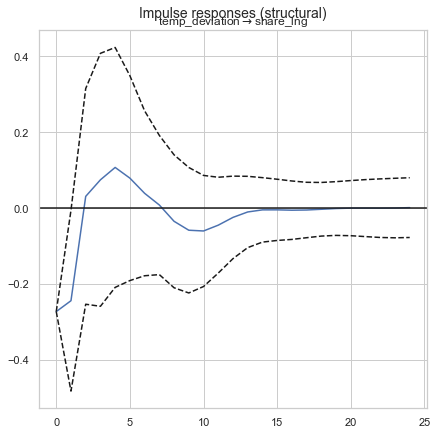

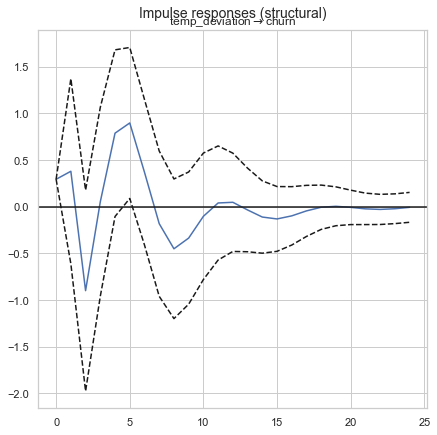

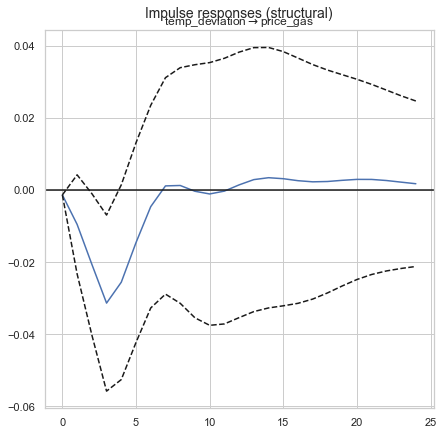

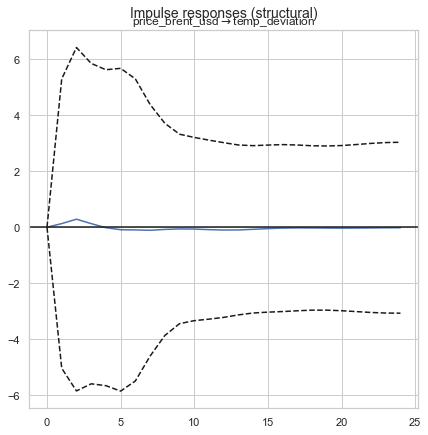

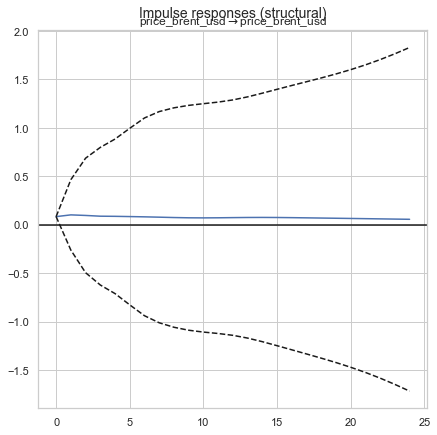

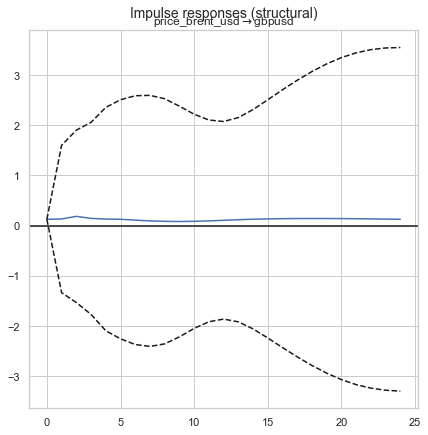

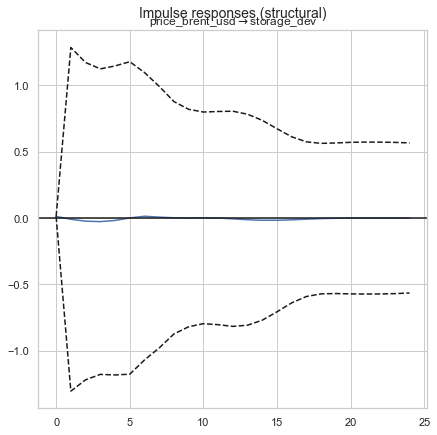

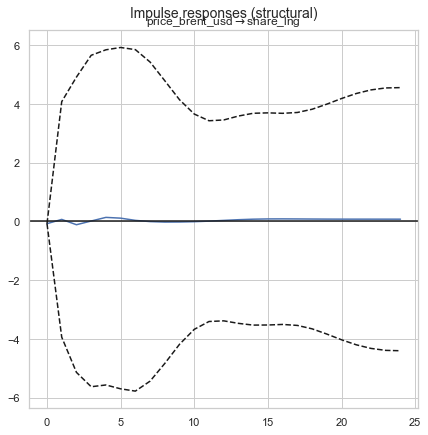

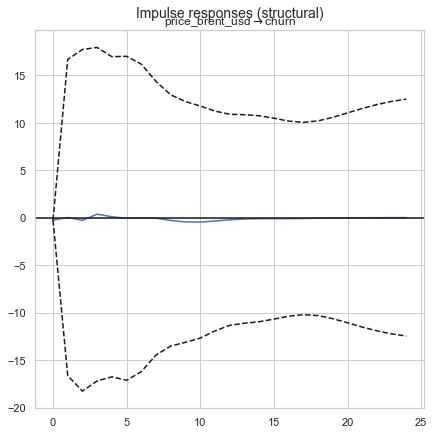

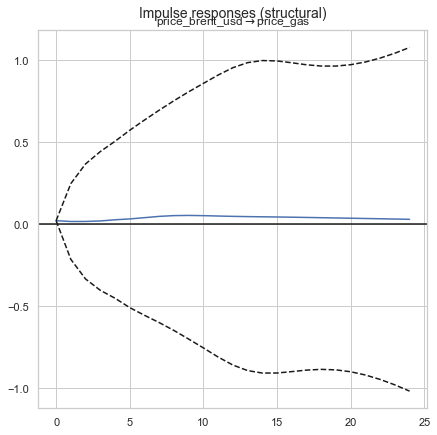

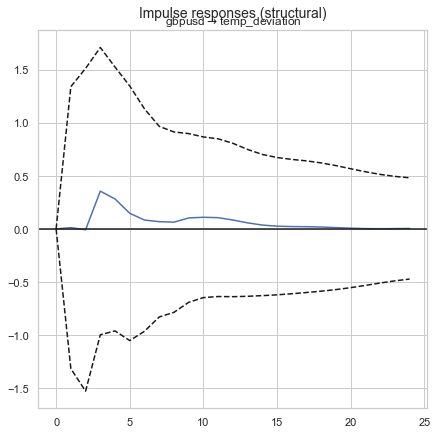

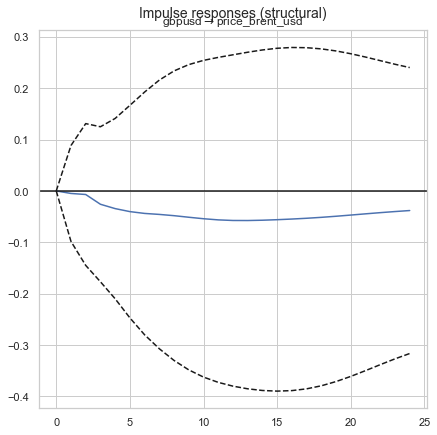

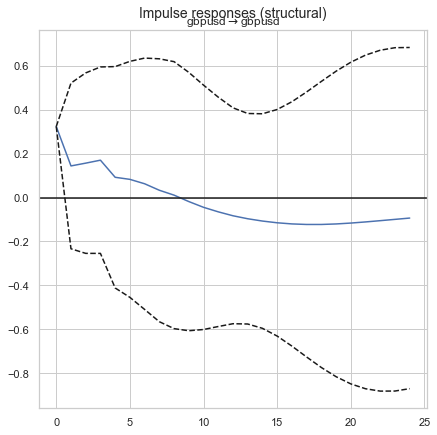

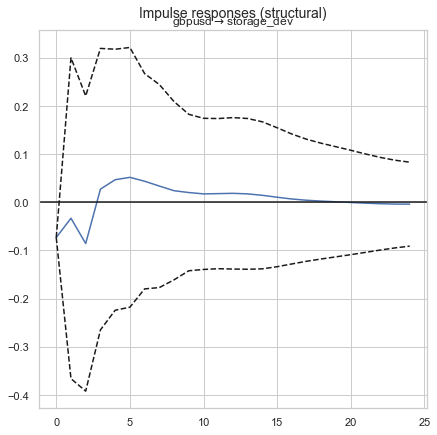

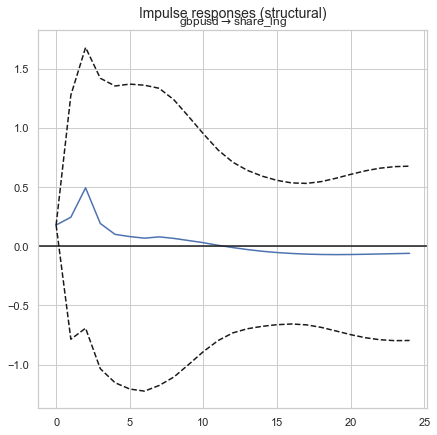

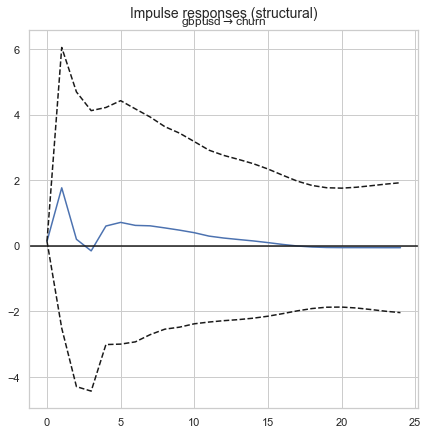

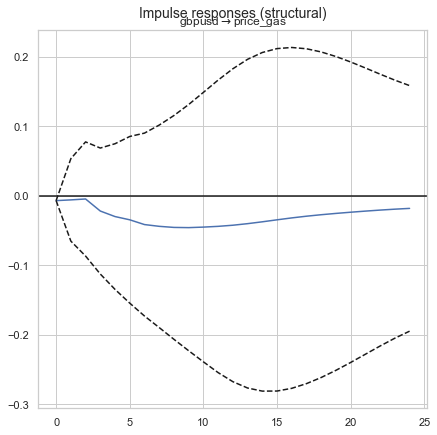

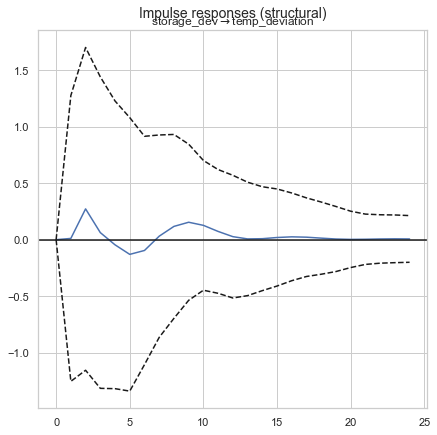

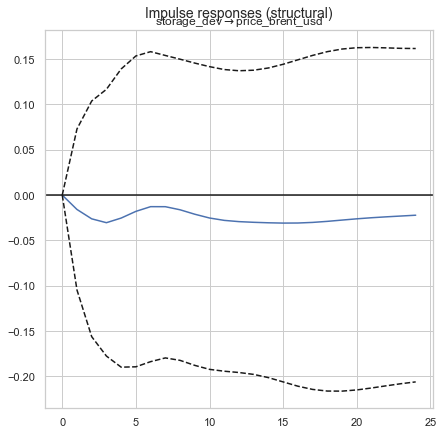

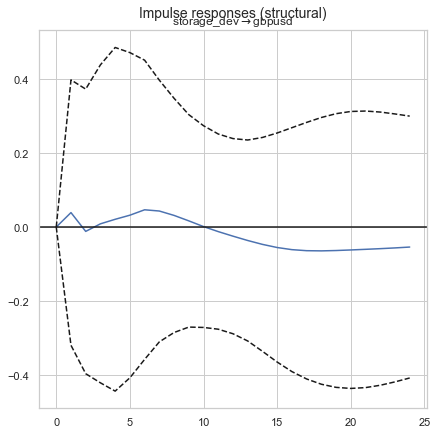

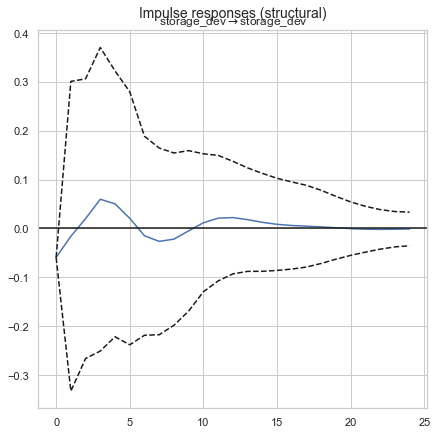

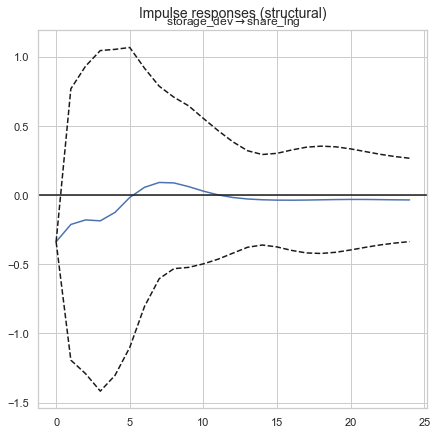

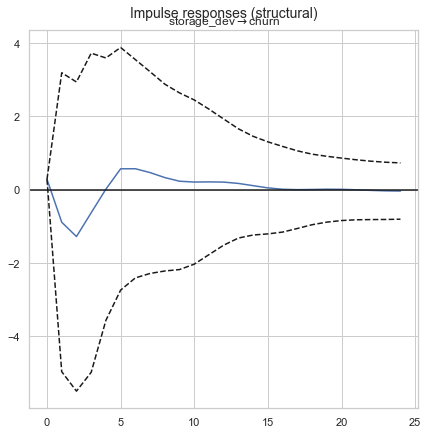

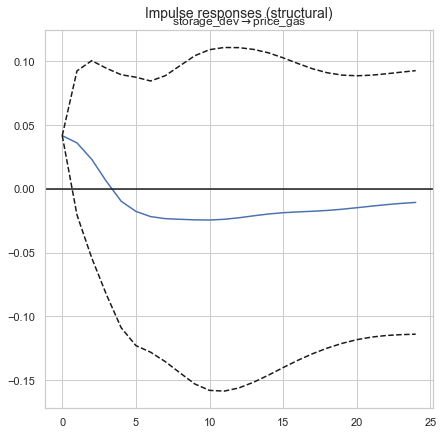

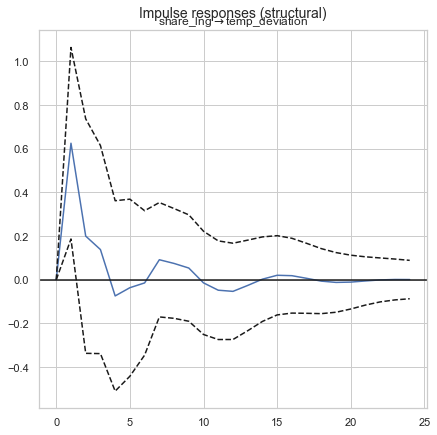

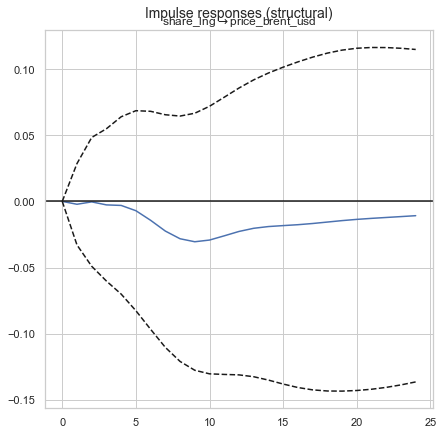

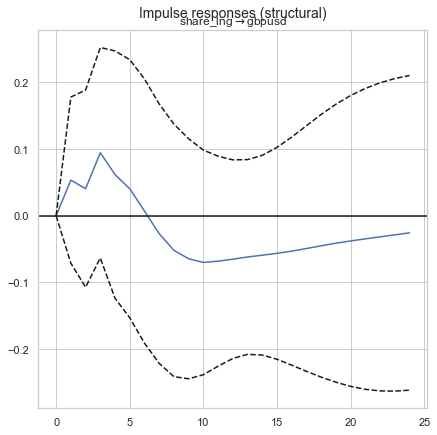

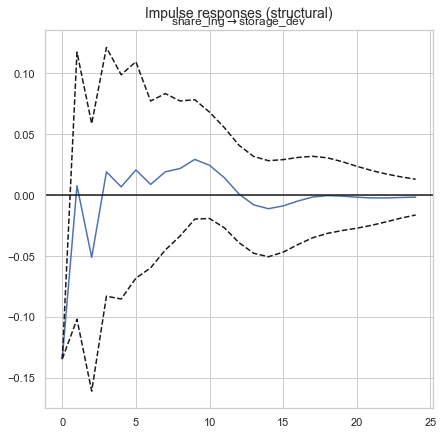

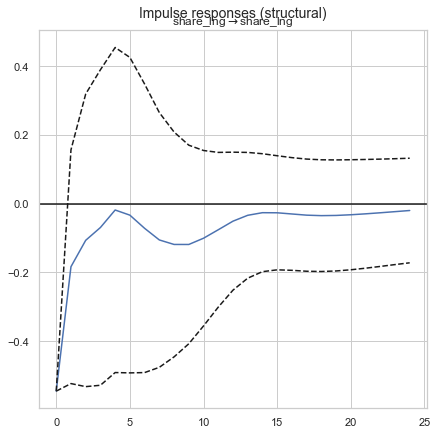

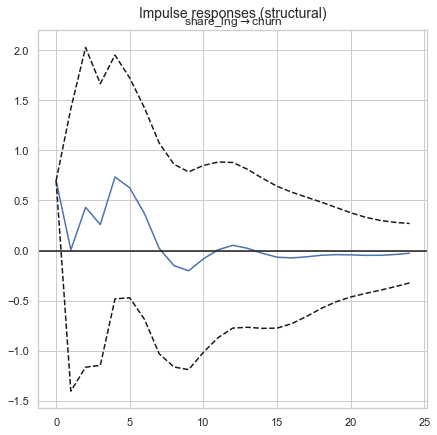

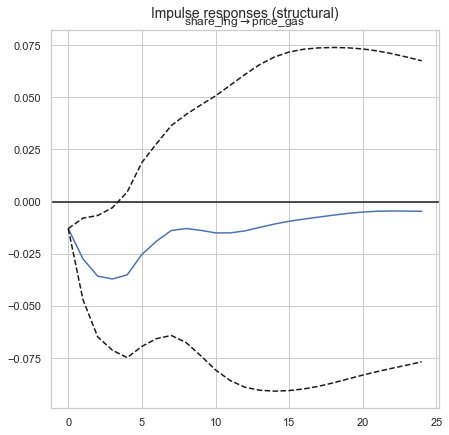

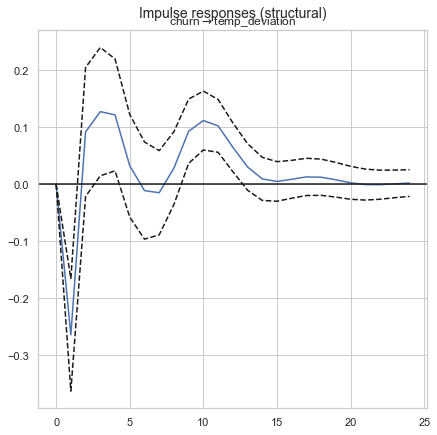

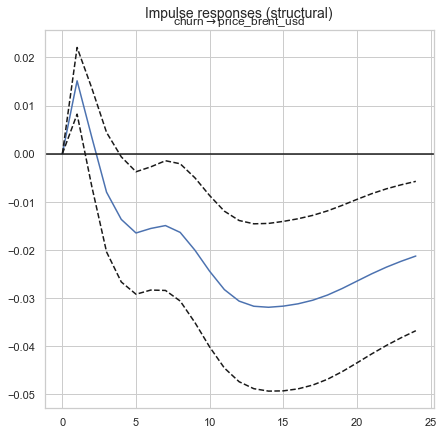

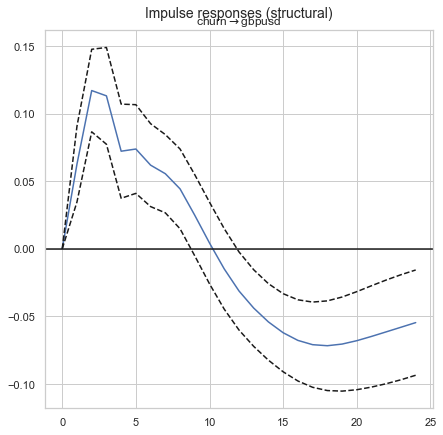

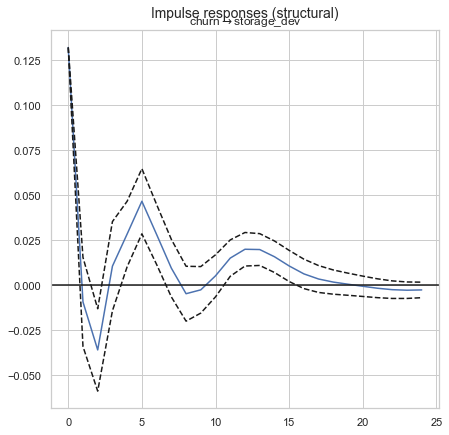

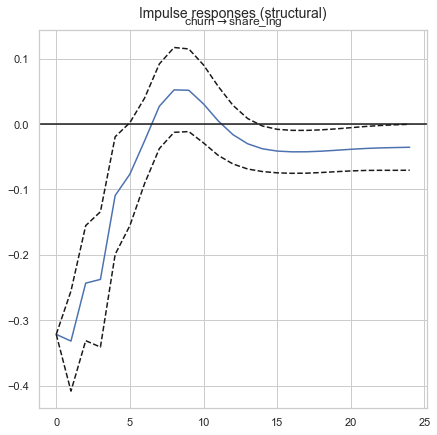

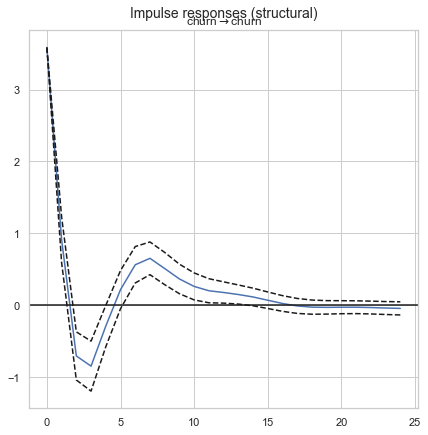

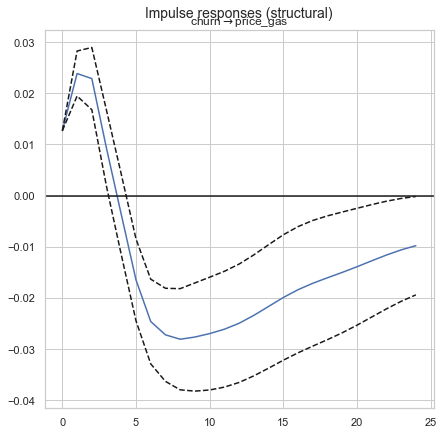

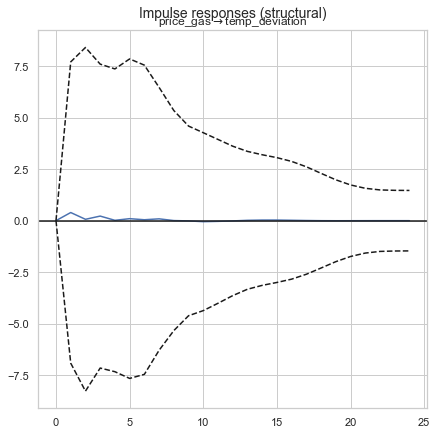

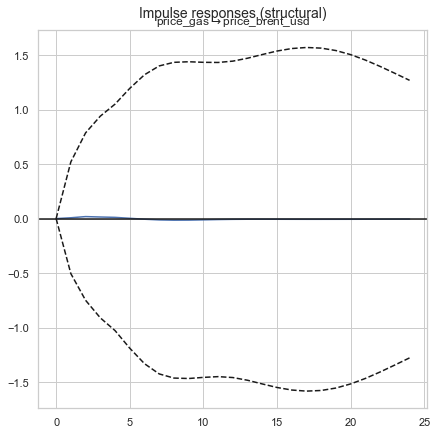

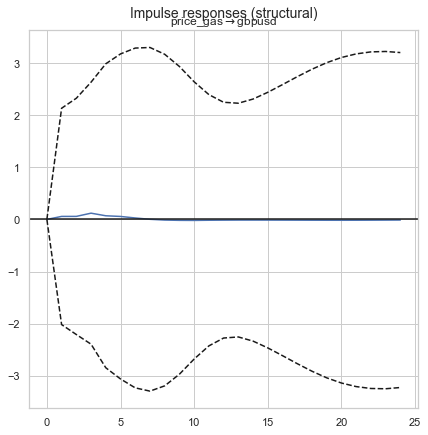

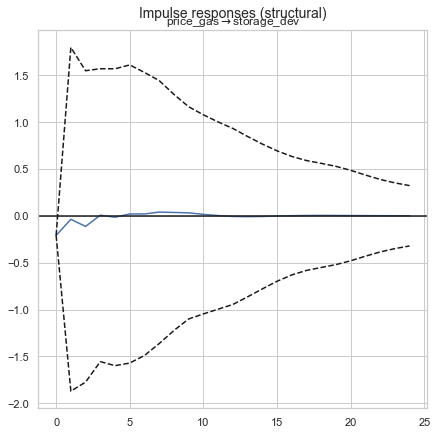

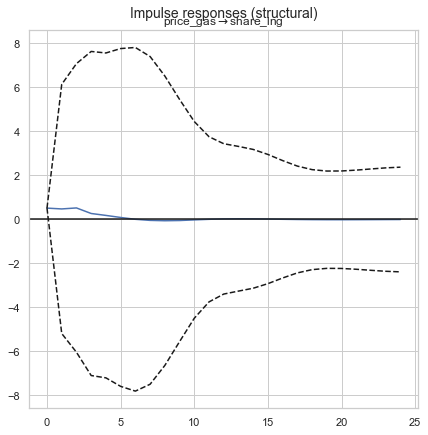

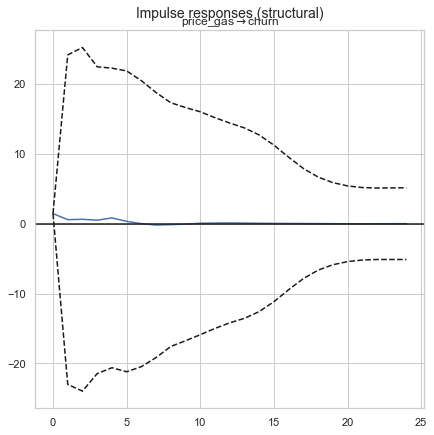

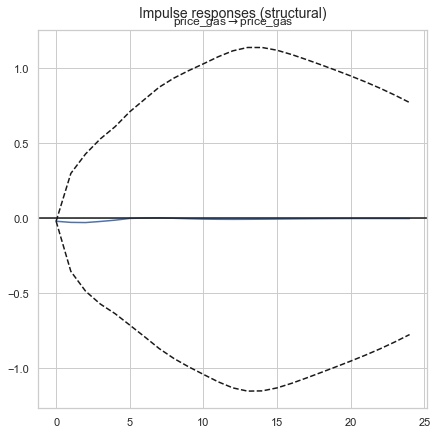

In [ ]:
### IR ###

ERRORTYPE='asym'

ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[0], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[1], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[2], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[3], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[4], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[5], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)

ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[0], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[1], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[2], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[3], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[4], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[5], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)
ResSVAR.irf(periods=Periods).plot(impulse=indexes[6], response=indexes[6], plot_stderr=plot_errband,stderr_type=ERRORTYPE, repl=Reps, figsize=FIGsize)









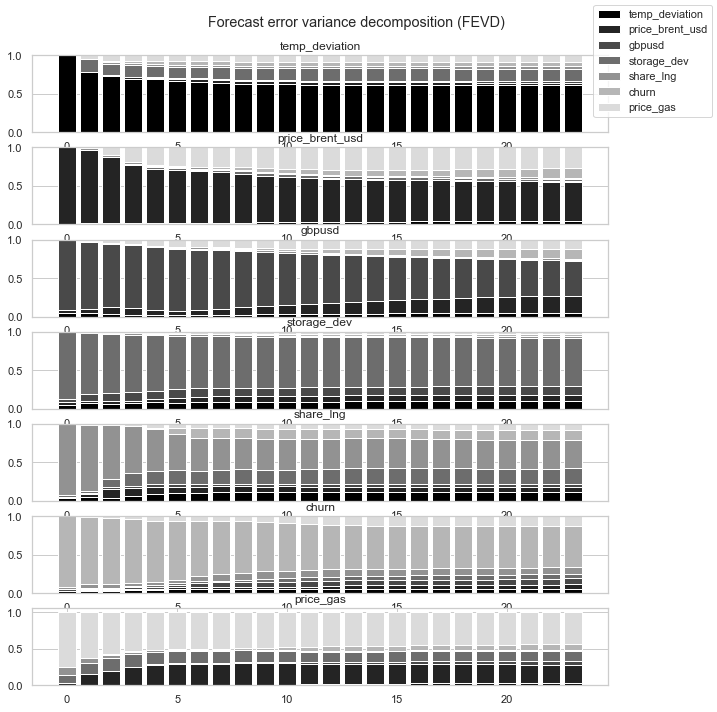

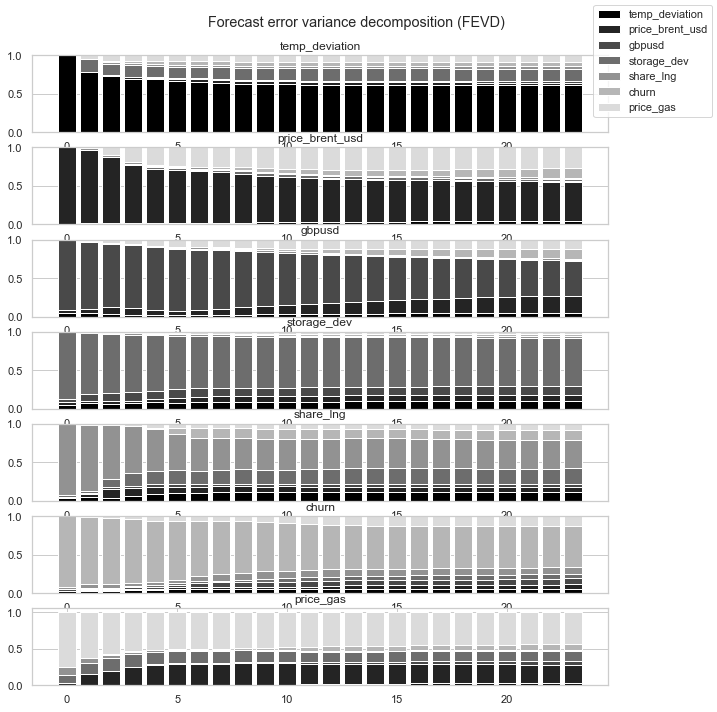

In [ ]:
#### FEVD ####

#only for 20 periods
n=24
fevd = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
model_fit.fevd(n).plot()

FEVD for temp_deviation
      temp_deviation  price_brent_usd    gbpusd  storage_dev  share_lng     churn  price_gas
0           1.000000         0.000000  0.000000     0.000000   0.000000  0.000000   0.000000
1           0.783323         0.003266  0.001615     0.160430   0.001358  0.005325   0.044683
2           0.724158         0.012788  0.001839     0.152026   0.015489  0.022641   0.071059
3           0.696708         0.016572  0.003738     0.156498   0.030021  0.027270   0.069193
4           0.686417         0.016940  0.009965     0.150021   0.029644  0.036427   0.070586
5           0.659333         0.035342  0.012003     0.142561   0.028182  0.049396   0.073183
6           0.653771         0.037957  0.012316     0.144139   0.028818  0.049244   0.073754
7           0.642211         0.036518  0.013400     0.153054   0.028160  0.047813   0.078844
8           0.629004         0.035975  0.013346     0.156959   0.027891  0.051695   0.085130
9           0.626704         0.036027  0.01330

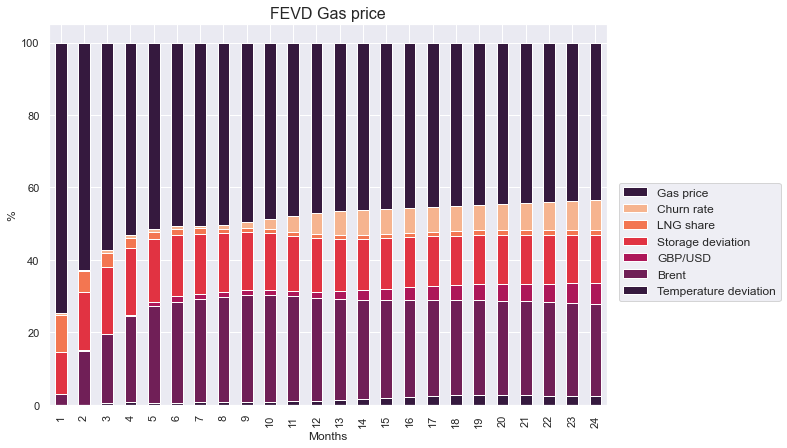

<Figure size 432x288 with 0 Axes>

In [ ]:
#print(dir(fevd))
#print(fevd.decomp)

index = 6

gas = fevd.decomp[6]

res = []
for i in range(0,len(gas)):
    sub=[]
    for y in gas[i]:
        sub.append(y*100)
    #print(i)
    #print(sub)
    res.append(sub)
    
#print(res)
fevd.summary()


fevd_temp=[]
fevd_brent=[]
fevd_gbp=[]
fevd_storage=[]
fevd_lng=[]
fevd_churn=[]
fevd_gas=[]

for i in range(0,len(res)):
    fevd_temp.append(res[i][0])
    fevd_brent.append(res[i][1])
    fevd_gbp.append(res[i][2])
    fevd_storage.append(res[i][3])
    fevd_lng.append(res[i][4])
    fevd_churn.append(res[i][5])
    fevd_gas.append(res[i][6])


df_fevd = pd.DataFrame({'Temperature deviation': fevd_temp,
                    'Brent':fevd_brent,
                    'GBP/USD': fevd_gbp,
                    'Storage deviation':fevd_storage,
                    'LNG share':fevd_lng,
                    'Churn rate': fevd_churn,
                    'Gas price':fevd_gas,
                    'period':np.linspace(1,24,24,dtype=int)})
 
sns.set_theme(style="darkgrid")

#bar1 = sns.barplot(x="period",  y="Temperature deviation", data=df_fevd)
#bar2 = sns.barplot(x="period",  y="Brent", data=df_fevd, color='grey')
#bar3 = sns.barplot(x="period",  y="GBP/USD", data=df_fevd, color='darkblue')
#bar4 = sns.barplot(x="period",  y="Storage deviation", data=df_fevd, color='darkblue')
#bar5 = sns.barplot(x="period",  y="LNG share", data=df_fevd, color='darkblue')
#bar6 = sns.barplot(x="period",  y="Churn rate", data=df_fevd, color='darkblue')
#bar7 = sns.barplot(x="period",  y="Gas price", data=df_fevd, color='darkblue')


df_fevd.set_index('period').plot(kind='bar', stacked=True, color=sns.color_palette("rocket"),figsize=(10, 7))
plt.title('FEVD Gas price', fontsize=16)
plt.xlabel('Months', fontsize=12)
plt.ylabel('%', fontsize=12)
plt.legend(reversed(plt.legend().legendHandles), reversed(df_fevd.columns[0:-1]),bbox_to_anchor=(1.01, 0.6), loc='upper left',fontsize=12)

plt.figure()

plt.savefig('fevd.png')


In [ ]:
from pydoc import describe
from statsmodels.tsa.vector_ar.irf import IRAnalysis
import numpy.linalg as npl
from statistics import stdev

##### ADAPT IMPULSE TO HAVE ONE OR TWO STDEV #####

fitted = ResSVAR
fitted.exog=None
fitted.trend='n'
T = 24 #periods


####

alpha = 1
P = np.dot(npl.inv(fitted.A), fitted.B)


J = fitted.svar_ma_rep(T,P=P)
shock= alpha*fitted.sigma_u
J = shock*np.array(J)


print(J[0])


#### calibration impulse

number_stdev = 1

print(df_corr.describe())
print(stdev(df_corr.temp_deviation))

indexes= ['temp_deviation', 'price_brent_usd', 'gbpusd', 'store_dev', lng_typo, 'churn', price_gas_typo]
var = 6
onestdev = stdev(df_corr.loc[:,indexes[var]])
print(onestdev)
print(J[0][var][var])
alpha = onestdev/J[0][var][var]*number_stdev
print(alpha)

######### actualised
alpha = 1

P = np.dot(npl.inv(fitted.A), fitted.B)
J = fitted.svar_ma_rep(T,P=P)
shock= alpha*fitted.sigma_u
J = shock*np.array(J)


print(J[0])
print(df_corr.describe())

[[ 1.84365828e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 2.97556389e-04  6.27286868e-04  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 2.01191696e-03  1.39926018e-03  3.92012235e-02 -0.00000000e+00
   0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 6.02824148e-03  5.19855579e-07  1.96478651e-03 -5.60302053e-03
   1.25361729e-02  9.32262201e-03 -1.25670450e-03]
 [ 1.00387374e-01  1.53603837e-04  1.21841345e-02  3.14244871e-02
  -4.92521625e-01  3.01944005e-01 -1.24146430e-02]
 [ 9.83915555e-02  6.13954451e-03 -8.01855901e-04  2.00140712e-02
  -6.55237110e-01  5.59635935e+01  1.85940376e-02]
 [ 7.08075037e-07  4.01274967e-05 -2.60139738e-06  2.49035101e-04
   3.14392139e-04  1.65666188e-04 -6.05050048e-05]]
       temp_deviation  price_brent_usd     gbpusd  storage_dev  share_lng  \
count    6.600000e+01        66.000000  66.000000    66.000000  66.000000   
mean    -1.515152e-03     

In [ ]:
G,H = fitted.sirf_errband_mc(steps=T, signif=0.05, burn=10, cum=False, repl=100)

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Pyt

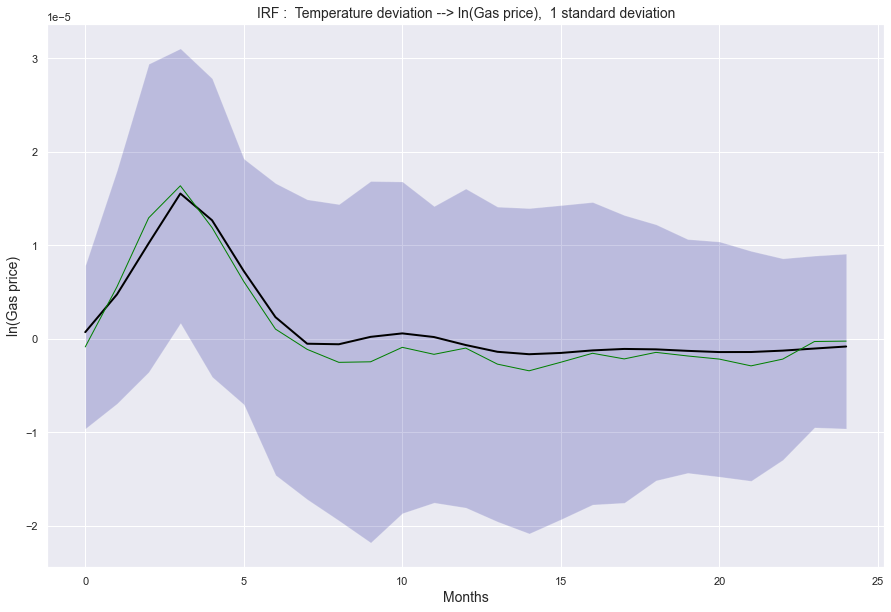

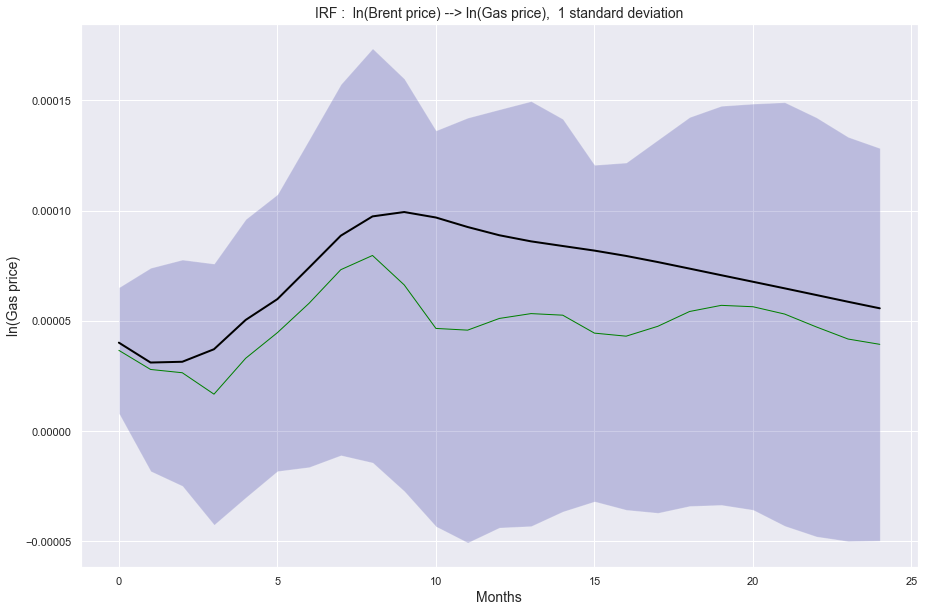

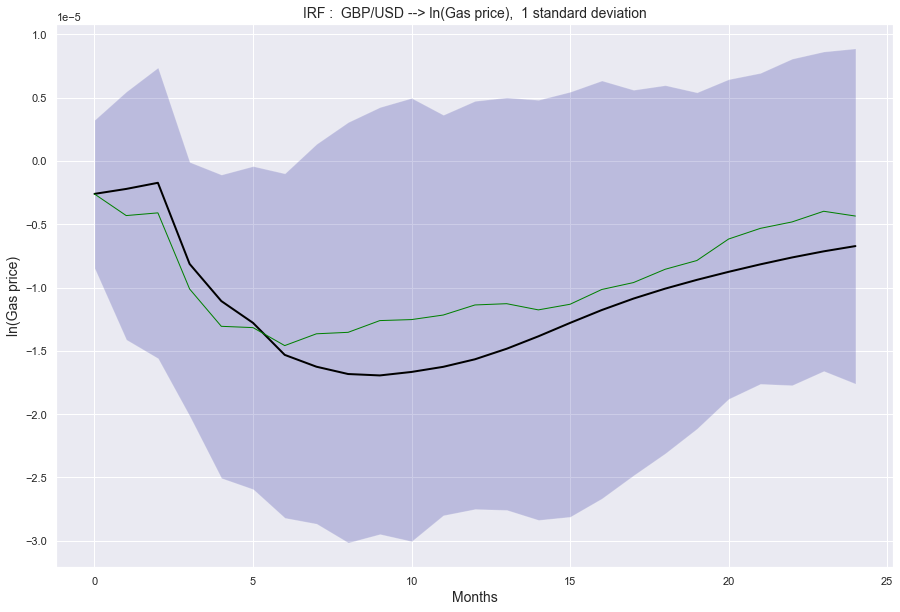

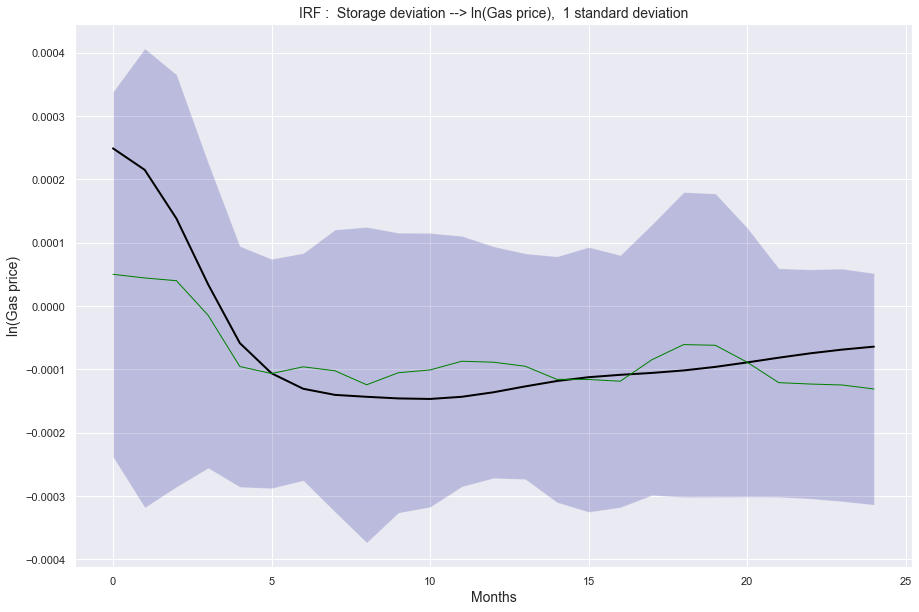

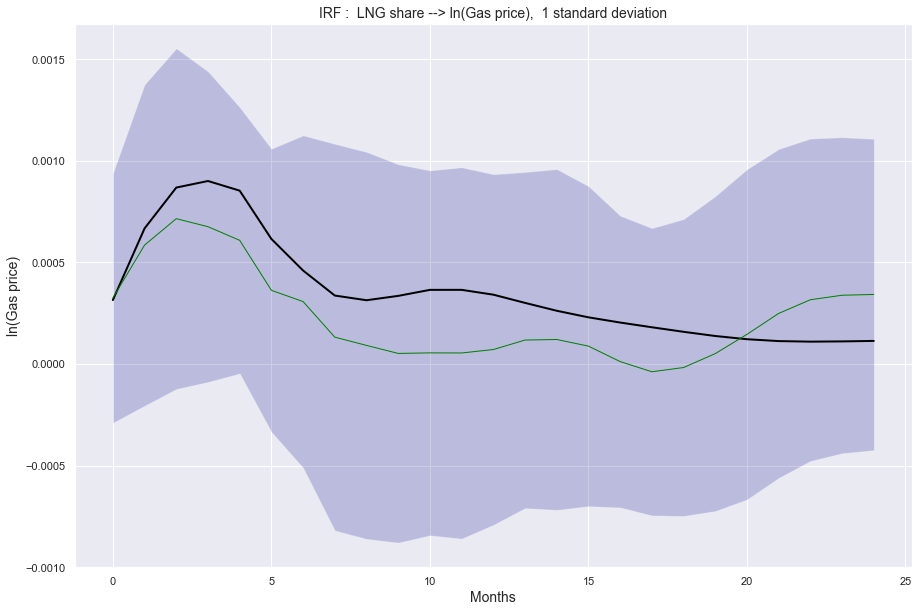

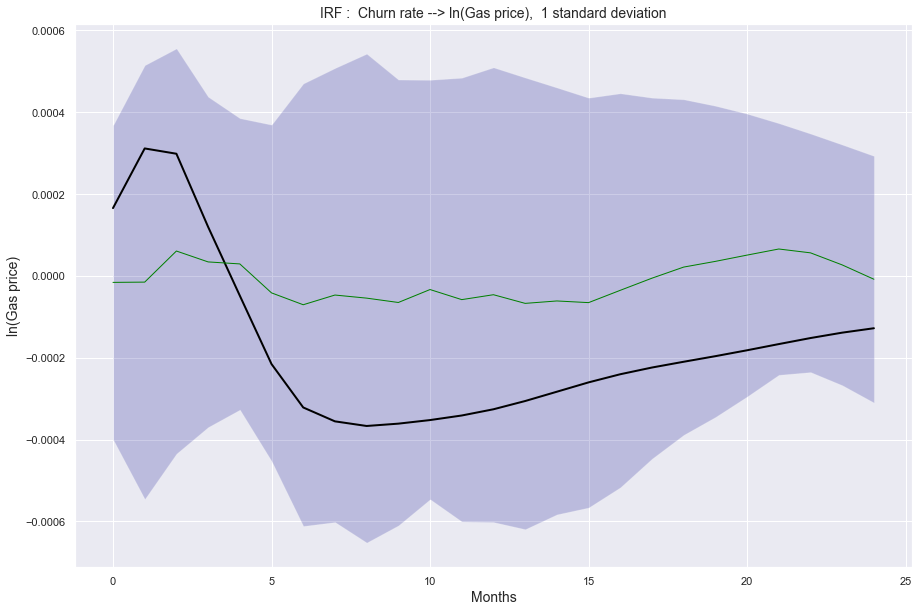

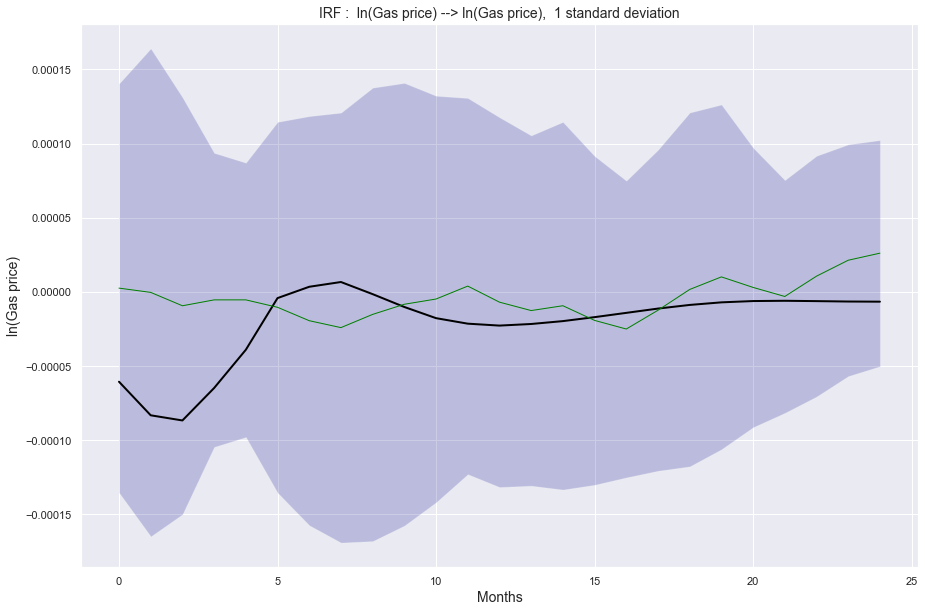

In [ ]:
time=np.linspace(0,24,25)

IRFtot=[]
for k in range(0,7):
    response=[]
    for j in range(0,7):
        temp=[]
        for i in range(0,len(J)):
            temp.append(J[i][j][k])
        response.append(temp)
    IRFtot.append(response)

# indexes for IRFtot , 1st index is the impact, 2nd is the impulse, 

##### ERROR BANDS ##### 
UpperBD=[]
LowerBD=[]

for k in range(0,7):
    response=[]
    for j in range(0,7):
        temp=[]
        for i in range(0,len(J)):
            temp.append(H[i][j][k]*shock[j][k])
        response.append(temp)
    UpperBD.append(response)

for k in range(0,7):
    response=[]
    for j in range(0,7):
        temp=[]
        for i in range(0,len(J)):
            temp.append(G[i][j][k]*shock[j][k])
        response.append(temp)
    LowerBD.append(response)

##### PLOTTING ##### 

import seaborn as sns
sns.set_theme(style="darkgrid")


impact = 6

indexes= ['Temperature deviation', 'ln(Brent price)', 'GBP/USD', 'Storage deviation', 'LNG share', 'Churn rate','ln(Gas price)']

for impulse in range(0,7):
    up=UpperBD[impulse][impact]
    y=IRFtot[impulse][impact]
    low=LowerBD[impulse][impact]
    mid=[(a + b)/2 for (a, b) in zip(up, low)] 
    x=time


    plt.figure(figsize=(15,10))
    plt.plot(x, y, linewidth=2, color='black')
    plt.plot(x, mid, linewidth=1, color='green')
    plt.fill_between(x,low, up, facecolor='darkblue', alpha=0.2)
    plt.xlabel("Months", fontsize=14)
    plt.ylabel(indexes[impact], fontsize=14)

    plt.title("IRF :  " +  indexes[impulse] +" --> " + indexes[impact] +',  ' + str(alpha) +  ' standard deviation', fontsize=14)
    plt.show()




FORECASTING BELOW:

In [ ]:
#### Forecast ####

#from fractions import Fraction


from numpy import linspace


yarray=df_corr.to_numpy()
#print(y)
y=yarray[119:,:]
print(y)
print(y.size)
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"

steps = 12
ForecastSVAR = ResSVAR.forecast(y,steps)

print(ForecastSVAR)
ForecastPriceGas = ForecastSVAR[:,6]

serie=yarray[:,6]
print(serie.size)
length=serie.size
xserie = np.linspace(0,length-1,length)
xforecast = np.linspace(length,length+steps,steps)

print(xserie.size)
print(xforecast.size)


print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()


[]
0


ValueError: y must by have at least order (3) observations. Got 0.

138
[ 61.1756115   65.28936011  69.35416951  73.53884185  77.69292703
  81.80814265  85.93189874  90.00729113  94.04763241  98.24709671
 102.47288347 106.66692436 110.75979068 114.80845862 118.93073387
 123.06177529 127.16843949 131.22004505 135.26345054 139.31420133
 143.38599643 147.51169237 151.71646527 155.94433343 160.17071835
 164.40176858 168.62220813 172.88209161 177.10240955 181.28850668
 185.4573146  189.65908972 193.83924884 198.03919174 202.2815195
 206.5491416  210.81397668 215.01459043 219.09665725 223.13892139
 227.05032577 230.85354801 234.55235803 238.19304774 241.93645579
 245.86543742 249.8578655  253.87650497 257.86723826 261.70963108
 265.61958159 269.4708848  273.28311933 277.02328673 280.77429469
 284.53462486 288.21975852 291.9306117  295.63030889 299.25894198
 302.82074326 306.29153858 309.66418057 313.01488974 316.34521529
 319.72377164 323.23546274 326.79131107 330.23840738 333.74189881
 337.55916013 341.45257829 345.27738853 349.23969481 353.14892254
 356.84

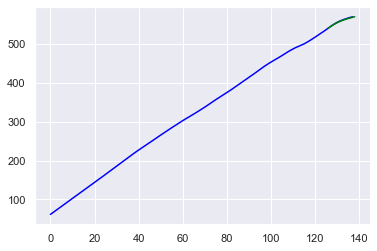

In [ ]:
#### DIFF INV ####
diff_total = np.concatenate((yarray[:,6], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,6].size + steps
print(length_set)
PriceReal = np.linspace(0,length_set,length_set)
PriceReal[0] = dprice_gas.values[0]

for i in range(1,length_set):
    PriceReal[i] = diff_total[i-1] + PriceReal[i-1]

print(PriceReal)
forecasted = PriceReal[-steps:]
print(forecasted)
print(PriceReal.size)

plt.plot(PriceReal, color='blue')
plt.plot(xforecast,forecasted,color="green")
plt.show()


(array([[-4.92221601,  4.23023041, 13.46565512, -0.48328815,  0.73072864,
        14.86582413,  4.11136877],
       [-3.90248048,  4.17636906, 13.32797987, -0.65526085, -0.07047283,
        15.63886441,  3.85932571],
       [-2.96911974,  4.016159  , 12.88564202, -0.73382074, -0.28430218,
        18.2044826 ,  3.55723364],
       [-1.87783388,  3.75907013, 12.5700591 , -0.67307817,  0.0773011 ,
        19.82327237,  3.18599586],
       [-1.30604186,  3.50685542, 12.19971652, -0.544688  ,  0.69696142,
        21.88457281,  2.7984018 ],
       [-0.98256708,  3.2821936 , 11.82583737, -0.4382657 ,  1.26860879,
        24.19377349,  2.45034874],
       [-0.86996628,  3.07545676, 11.44799036, -0.33797081,  1.58707352,
        26.14234211,  2.16523167],
       [-0.82042261,  2.87852134, 11.0524104 , -0.30809854,  1.72272736,
        26.99557858,  1.95013892],
       [-0.68577393,  2.68706596, 10.6499138 , -0.29933087,  1.68503323,
        26.71635009,  1.79589456],
       [-0.58238577,  2.505

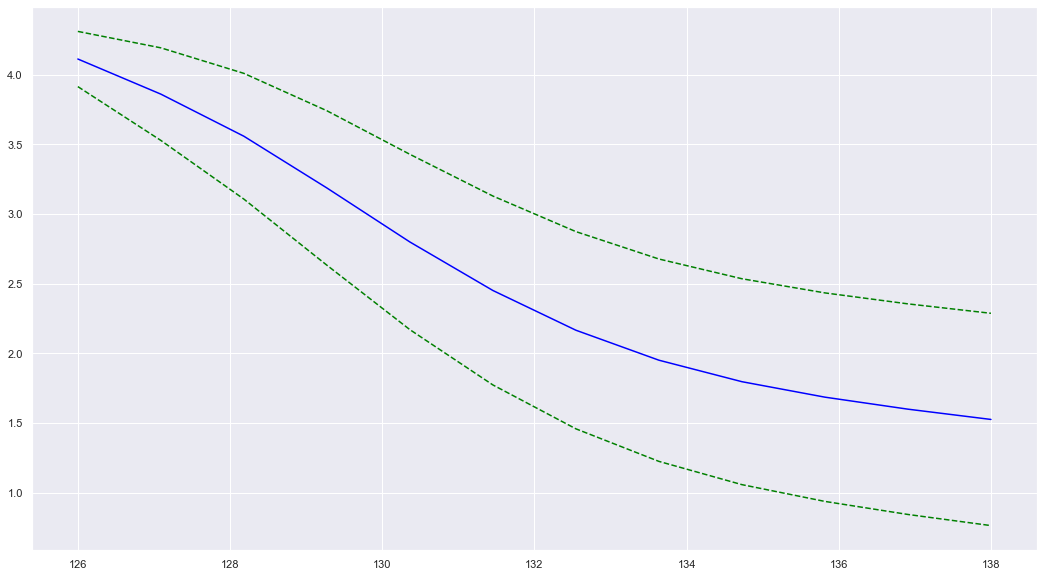

[266.30304868 269.83018422 272.93628135 275.56814943 277.73747165
 279.51007286 280.96773597 282.19178    283.24895115 284.18568888
 285.02882474 285.79213377]


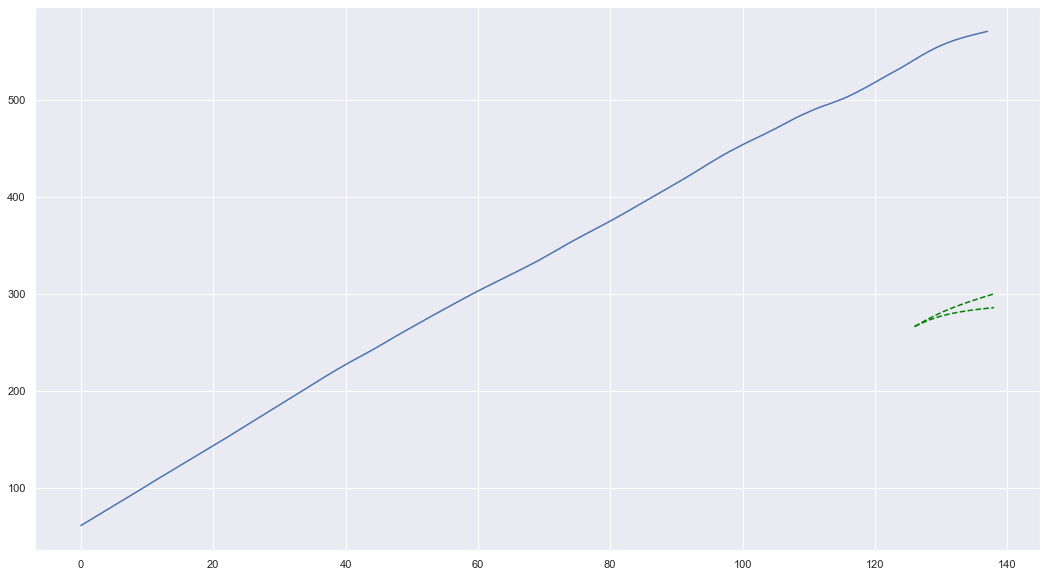

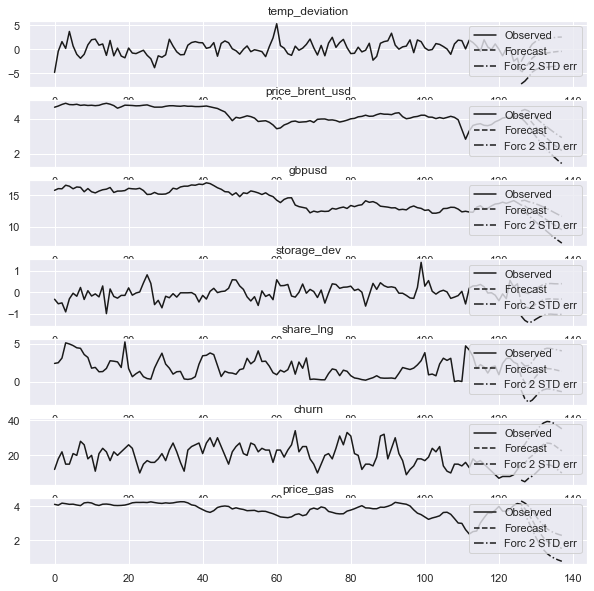

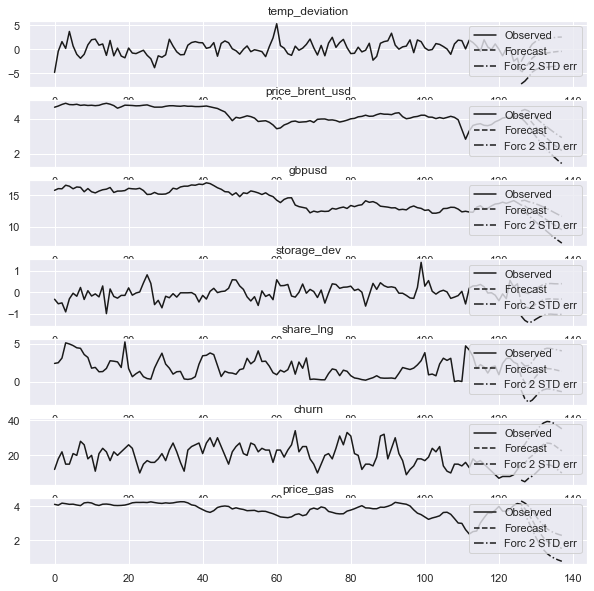

In [ ]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)

# differenciated
UpBandDiff = ForecastIntSVAR[2][:,6]
LowBandDiff = ForecastIntSVAR[1][:,6]
MidDiff = ForecastIntSVAR[0][:,6]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBandDiff, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBandDiff, color="green",linestyle='dashed')
plt.plot(xforecast,MidDiff,color="blue")
plt.show()


# integrated
last_val = dprice_gas.values[-1]

UpBand = UpBandDiff
LowBand = LowBandDiff 

UpBand[0] = last_val
LowBand[0] = last_val

for i in range(1,steps):
    UpBand[i] = UpBand[i-1] + UpBandDiff[i]
    LowBand[i] = LowBand[i-1] + LowBandDiff[i]

print(LowBand)
xforecast = np.linspace(length,length+steps,steps)

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color ="green",linestyle='dashed')
plt.plot(PriceReal)
plt.show()

ResSVAR.plot_forecast(steps)

#ResSVAR.plotsim()

In [ ]:
variables = ['temp_deviation','price_brent_usd','gbpusd','storage_dev',lng_typo,'churn',price_gas_typo]

for var in variables:
    long_run = ResSVAR.test_inst_causality(var)
    print(long_run.summary())

Instantaneous causality Wald-test. H_0: temp_deviation does not instantaneously cause [price_brent_usd, gbpusd, storage_dev, share_lng, churn, price_gas]. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         12.32          12.59   0.055  6
----------------------------------------
Instantaneous causality Wald-test. H_0: price_brent_usd does not instantaneously cause [temp_deviation, gbpusd, storage_dev, share_lng, churn, price_gas]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         15.23          12.59   0.019  6
----------------------------------------
Instantaneous causality Wald-test. H_0: gbpusd does not instantaneously cause [temp_deviation, price_brent_usd, storage_dev, share_lng, churn, price_gas]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
-----------

(array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+0

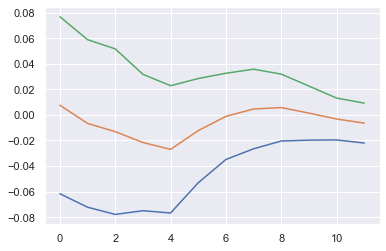

12
12
[266.30304868 270.42196181 274.27460228 277.81873393 280.98312987
 283.75457957 286.19263085 288.35671884 290.31147453 292.11309982
 293.79936103 295.39487216]
266.303048676345
[4.118913134280533, 3.8526404682889432, 3.5441316530195315, 3.16439593556178, 2.771449698249135, 2.438051279982139, 2.164087996196979, 1.9547556897986216, 1.8016252902618801, 1.6862612047983123, 1.5955111283147632, 1.5185951044096164]
12


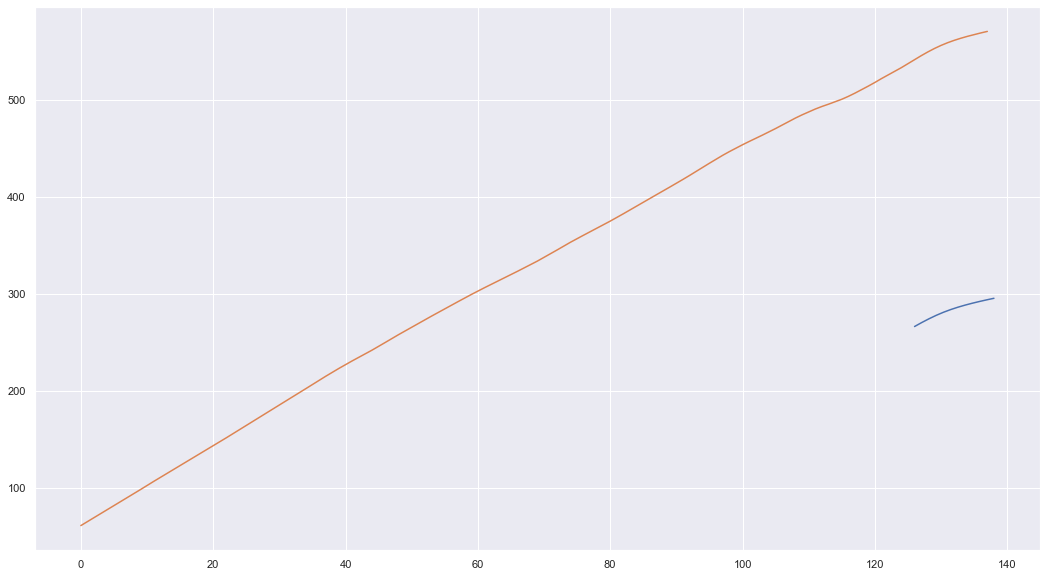

In [ ]:
#### SCENARIOS FORECAST ####

ResimBand = ResSVAR.irf_errband_mc(steps=steps,cum=False) #Tuple of lower and upper arrays of ma_rep monte carlo standard errors
Resim = ResSVAR.irf_resim()
print(ResimBand)

print(ResimBand[0])
UpperBand = []
LowerBand = []
Mid = []

for i in range(1,steps+1):
    UpperBand.append(ResimBand[0][i][3][4])
    LowerBand.append(ResimBand[1][i][3][4])



print("---------------------------")
print(UpperBand)

print("---------------------------")
print(LowerBand)


for i in range(0, steps):
    Mid.append((UpperBand[i] + LowerBand[i])/2)


plt.plot(UpperBand)
plt.plot(Mid)
plt.plot(LowerBand)
plt.show()

###########################

MidDiffTot = []
diff_forecast = diff_total[-steps:]
print(len(diff_forecast))
print(len(Mid))
for i in range(0,len(Mid)):
    MidDiffTot.append(Mid[i] + diff_forecast[i])

MidImp = np.linspace(0,steps,steps)
MidImp[0] = last_val

for i in range(1,steps):
    MidImp[i] = MidImp[i-1] + MidDiffTot[i-1]

print(MidImp)
print(last_val)
print(MidDiffTot)
print(len(MidImp))
plt.figure(figsize=(18, 10))
plt.plot(xforecast,MidImp)
plt.plot(PriceReal)
plt.show()

FORECAST FOR NON DIFFERENTIATED VALUES:

[[-4.83833333  4.64324144 15.8293     -0.32        2.394089   12.
   4.11374861]
 [-0.44        4.71026691 16.10047    -0.53        2.484395   18.
   4.0648094 ]
 [ 1.54666667  4.8006649  16.07407    -0.49        3.09434    22.
   4.18467234]
 [ 0.13833333  4.86674528 16.65002    -0.91        5.085389   15.
   4.15408518]
 [ 3.65333333  4.79260134 16.48777    -0.3         4.940239   15.
   4.11521562]
 [ 0.65666667  4.78353382 16.07588    -0.04        4.730679   21.
   4.12375609]
 [-1.08666667  4.80985955 16.36849    -0.18        4.439141   20.
   4.07539239]
 [-1.90833333  4.74766664 16.30763     0.23        4.371981   28.
   4.04034129]
 [-1.08        4.76955322 15.59941    -0.33        3.558559   26.
   4.19946429]]
9
[0 1 2 3 4 5 6 7 8]
[ 9 10 11]



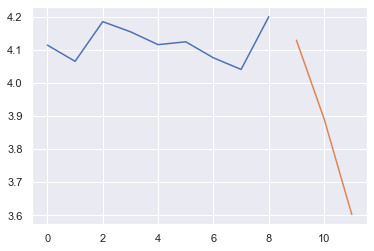

In [ ]:
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"

steps = 3
index = steps*3
df_forecast=df_corr.head(index)
yarray=df_forecast.to_numpy()
print(yarray)


ForecastSVAR = ResSVAR.forecast(yarray,steps)
ForecastPriceGas = ForecastSVAR[:,6]

serie=yarray[:,6]
print(serie.size)
length=serie.size
xserie = np.linspace(0,length-1,length,dtype=int)
xforecast = np.linspace(length,length+steps-1,steps,dtype=int)

print(xserie)
print(xforecast)

print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()

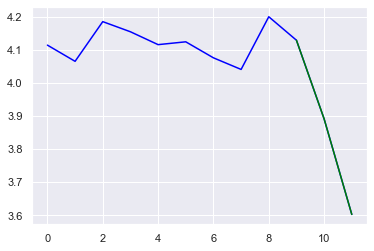

In [ ]:
total = np.concatenate((yarray[:,6], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,6].size + steps

plt.plot(total, color='blue')
plt.plot(xforecast,ForecastPriceGas,color="green")
plt.show()

(array([[-4.92221601,  4.23023041, 13.46565512, -0.48328815,  0.73072864,
        14.86582413,  4.11136877],
       [-3.90248048,  4.17636906, 13.32797987, -0.65526085, -0.07047283,
        15.63886441,  3.85932571],
       [-2.96911974,  4.016159  , 12.88564202, -0.73382074, -0.28430218,
        18.2044826 ,  3.55723364]]), array([[-7.23538559,  4.0301424 , 12.79708044, -1.09815473, -1.08729141,
         5.96058839,  3.91330598],
       [-6.6583494 ,  3.83832611, 12.42624611, -1.30413796, -2.21052088,
         5.01264088,  3.52713554],
       [-5.80881317,  3.59740154, 11.77596648, -1.41063628, -2.67964178,
         6.92723395,  3.10609713]]), array([[-2.60904643e+00,  4.43031843e+00,  1.41342298e+01,
         1.31578434e-01,  2.54874870e+00,  2.37710599e+01,
         4.30943156e+00],
       [-1.14661157e+00,  4.51441201e+00,  1.42297136e+01,
        -6.38373144e-03,  2.06957523e+00,  2.62650879e+01,
         4.19151588e+00],
       [-1.29426322e-01,  4.43491646e+00,  1.39953176e+01,


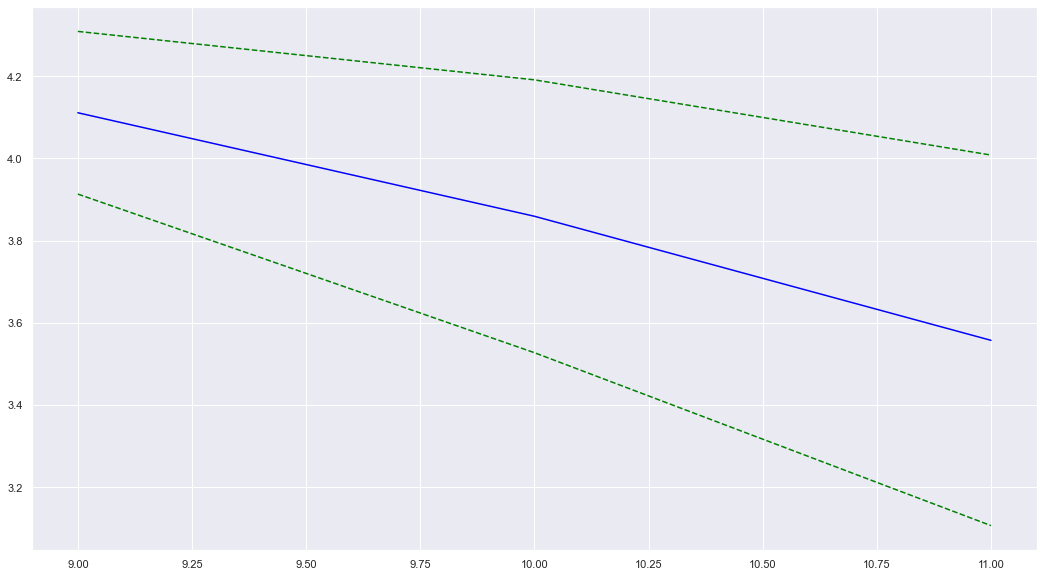

In [ ]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)

# differenciated
UpBand = ForecastIntSVAR[2][:,6]
LowBand = ForecastIntSVAR[1][:,6]
Mid = ForecastIntSVAR[0][:,6]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color="green",linestyle='dashed')
plt.plot(xforecast,Mid,color="blue")
plt.show()

In [ ]:
index=25
df_corr.head(index)

temp_deviation  price_brent_usd    gbpusd  storage_dev  share_lng  churn  \
15       -4.838333         4.643241  15.82930        -0.32   2.394089   12.0   
16       -0.440000         4.710267  16.10047        -0.53   2.484395   18.0   
17        1.546667         4.800665  16.07407        -0.49   3.094340   22.0   
18        0.138333         4.866745  16.65002        -0.91   5.085389   15.0   
19        3.653333         4.792601  16.48777        -0.30   4.940239   15.0   
20        0.656667         4.783534  16.07588        -0.04   4.730679   21.0   
21       -1.086667         4.809860  16.36849        -0.18   4.439141   20.0   
22       -1.908333         4.747667  16.30763         0.23   4.371981   28.0   
23       -1.080000         4.769553  15.59941        -0.33   3.558559   26.0   
24        0.881667         4.742117  16.11188         0.08   3.174312   18.0   
25        1.940000         4.754036  15.59795        -0.17   1.772939   20.0   
26        2.068333         4.729976  15.41592        -0.07   1.874229   11.0   
27        0.811667         4.751392  15.70845        -0.21   1.300236   21.0   
28        1.060000         4.822158  15.92205         0.30   1.327014   24.0   
29       -1.303333         4.864607  16.01691        -0.99   1.738437   22.0   
30        1.788333         4.815089  16.28134         0.16   2.740620   17.0   
31       -1.396667         4.734424  15.48299        -0.19   2.685371   22.0   
32        0.206667         4.587884  15.70697        -0.27   2.595420   20.0   
33       -1.436667         4.664989  15.71339        -0.14   1.862464   22.0   
34       -1.808333         4.758975  15.79031        -0.14   5.207668   24.0   
35        0.220000         4.750102  16.14518         0.21   1.718310   26.0   
36       -0.818333         4.740249  16.07459        -0.13   0.658363   24.0   
37       -0.935000         4.720990  16.04107        -0.03   1.047486   17.0   
38       -0.581667         4.727622  16.16292         0.02   1.351025   10.0   
39       -0.238333         4.755870  15.79779         0.44   0.658343   15.0   

    price_gas  
15   4.113749  
16   4.064809  
17   4.184672  
18   4.154085  
19   4.115216  
20   4.123756  
21   4.075392  
22   4.040341  
23   4.199464  
24   4.225787  
25   4.194041  
26   4.092866  
27   4.048668  
28   4.122275  
29   4.131041  
30   4.106664  
31   4.051606  
32   4.043405  
33   4.050751  
34   4.071795  
35   4.125696  
36   4.204773  
37   4.227868  
38   4.226385  
39   4.231050

In [ ]:
def do_forecast(index,steps,M,set):
    yarray=set.to_numpy()
    #A = np.asarray([['E', 0, 0, 0, 0, 0, 0], ['E', 'E', 0, 0, 0, 0, 0],['E', 'E', 'E', 0, 0, 0, 0],['E', 'E', 0, 'E', 0, 0, 'E'],['E', 'E', 0, 'E', 'E', 0, 'E'],['E', 'E', 'E', 'E', 'E', 'E', 0],['E', 'E', 'E', 'E', 'E', 'E', 'E']])
    #StructModel = SVAR(set,svar_type='A', A=A)
    #ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=100000, maxfun=100000, solver='bfgs')
    #ResSVAR.exog=None
    #ResSVAR.coefs_exog=np.array(0)
    #ResSVAR.trend='n'
    ForecastSVAR = ResSVAR.forecast(yarray,steps)
    ForecastPriceGas = ForecastSVAR[:,6][0]

    ### error bands
    ForecastIntSVAR = ResSVAR.forecast_interval(yarray,steps)
    UpBand = ForecastIntSVAR[2][:,6][0]
    LowBand = ForecastIntSVAR[1][:,6][0]

    return [ForecastPriceGas,UpBand,LowBand]

index=126
set=df_correction.head(index)
print(set)
fcst = do_forecast(index,3,1,set)
print(fcst)

     temp_deviation  price_brent_usd    gbpusd  storage_dev  share_lng  churn  \
15        -4.838333         4.643241  15.82930        -0.32   2.394089   12.0   
16        -0.440000         4.710267  16.10047        -0.53   2.484395   18.0   
17         1.546667         4.800665  16.07407        -0.49   3.094340   22.0   
18         0.138333         4.866745  16.65002        -0.91   5.085389   15.0   
19         3.653333         4.792601  16.48777        -0.30   4.940239   15.0   
..              ...              ...       ...          ...        ...    ...   
136       -1.390000         4.027565  13.93000        -0.07   2.392887    8.0   
137        0.146667         4.069541  13.74665        -0.29   3.035984    8.0   
138        0.188333         4.052141  13.95284         0.56   3.085292    8.0   
139       -2.496667         4.099967  14.18037         0.25   2.561482    9.0   
140       -1.893333         4.156097  13.84275         0.40   2.328330   12.0   

     price_gas  
15    4.11

In [ ]:
##### compare forecast and actual value #####

from math import exp

def compare_forecast_real(index,M,price,up,low):
    
    #### actual price comparison####
    index_price_real = index + M
    price_real = df_corr.loc[index_price_real]
    #print(price_real)
    price_real_sing = price_real[6]
    #print(price_real_sing)
    price=price
    #### diff forecast ####
    error = (price-price_real_sing)/price_real_sing*100
    #print(error)
    #### is within the errorbands ?
    valid = price_real_sing < up and price_real_sing > low
    #print(valid)



    ##### comparison naive
    price_before = df_corr.loc[index_price_real-1]
    price_before_sing = price_before[6]
    error_naive = (price_before_sing-price_real_sing)/price_real_sing*100
    #print(error_naive)

    return [error,valid,error_naive]
 

print(compare_forecast_real(index,1,fcst[0],fcst[1],fcst[2]))



[73.61689560338924, False, 10.907648452057508]


In [ ]:
##### evalutate forecast over long period #####
start=15
end=148
M=1

list_error = []
list_bands = []
list_error_naive = []
error_fit=[]


for index in range(start,end+1):
    #print(index)
    train_set=df_corr.head(index)

    forecasted = do_forecast(index,steps=3,M=M, set=train_set)
    comp = compare_forecast_real(index,1,forecasted[0],forecasted[1],forecasted[2])
    list_error.append(comp[0])
    list_bands.append(comp[1])
    list_error_naive.append(comp[2])
        #error_fit.append(index)



    

############### PLOT ERROR BANDS ###################

print('errors split')
print(list_bands.count(True))
print(list_bands.count(False))


############### PLOT ERRORS % ###################
xforecast = data_df.loc[start:end]['months']
level=5 # in percentages
line = np.zeros((1,len(xforecast)))[0]
lineup = [a+level for a in line]
linedown = [a-level for a in line]


plt.figure(figsize=[15,10])
plt.plot(xforecast,list_error)    
plt.fill_between(xforecast,lineup, linedown, facecolor='green', alpha=0.2)

plt.xlabel('Months',size=15)
plt.ylabel('Forecasting relative error (%)',size=15)
ax = plt.gca()
plt.xticks(rotation=90)
for label in ax.get_xaxis().get_ticklabels()[::2]:
    label.set_visible(False)
        
plt.show()


############### PLOT HIST ###################

plt.figure(figsize=[15,10])
plt.hist(list_error, bins=50)
plt.xlabel('%',size=15)
plt.ylabel('Forecasting relative error distribution',size=15)
plt.show()

from matplotlib import gridspec

fig = plt.figure(figsize=[14,10])
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 

ax1=plt.subplot(gs[0])
plt.xticks(rotation=90)


ax2=plt.subplot(gs[1])

ax1.plot(xforecast,list_error)
ax1.fill_between(xforecast,lineup, linedown, facecolor='green', alpha=0.2)
ax1.set_xlabel('Months',size=17)
ax1.set_ylabel('Forecasting relative error (%)',size=17)
for label in ax1.get_xticklabels():
    label.set_fontsize(12)
for label in ax1.get_xaxis().get_ticklabels()[::2]:
    label.set_visible(False)


ax2.hist(list_error, orientation='horizontal', alpha=.5, bins=50)
ax2.set_xlabel('Observations',size=17)
# note this needs to be ax2 due to subtle overlay issues....
ax2.set_ylabel('Forecasting relative error distribution (%)',size=17)
#ax2.get_yaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()


############### descriptive stats ###################
df_errors=pd.DataFrame({'errors':list_error})
print(df_errors.describe())
print('skewness',df_errors.skew())
print('kurtosis',df_errors.kurt())


NameError: name 'df_corr' is not defined

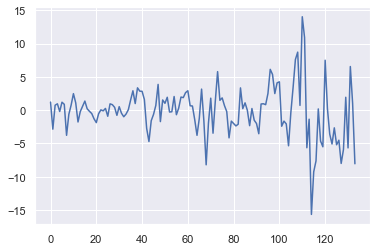

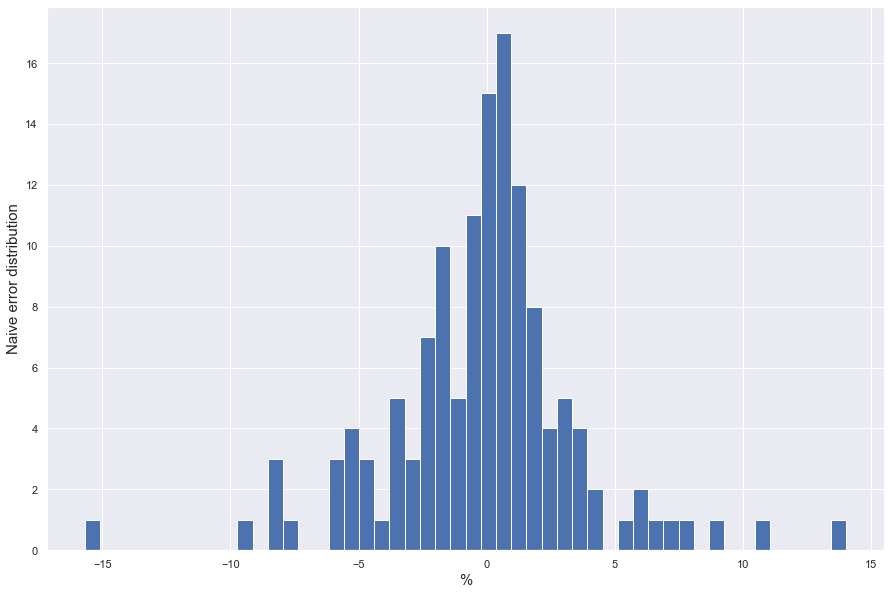

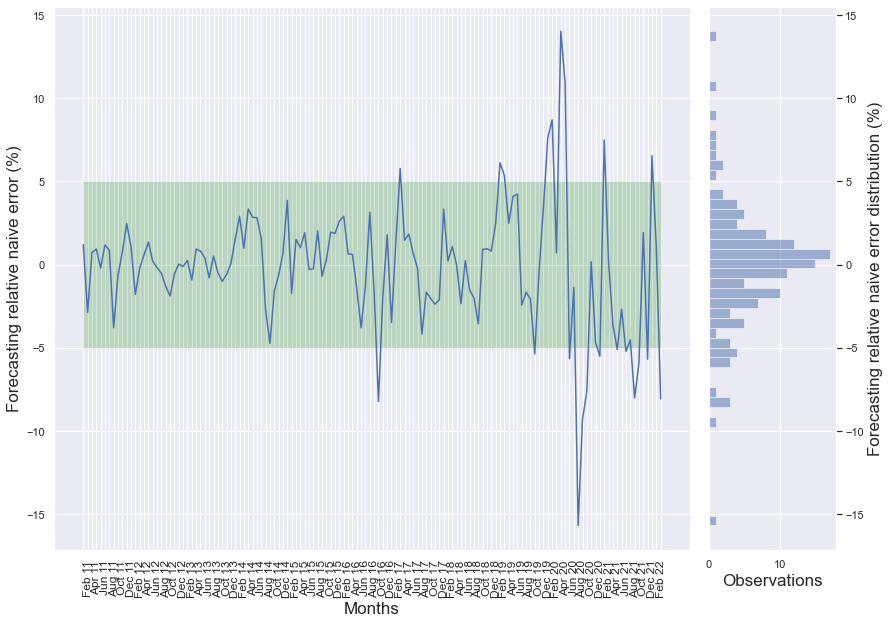

In [ ]:
############### errors naive plot #########################

plt.plot(list_error_naive)
plt.show()

plt.figure(figsize=[15,10])
plt.hist(list_error_naive, bins=50)
plt.xlabel('%',size=15)
plt.ylabel('Naive error distribution',size=15)
plt.show()

from matplotlib import gridspec

fig = plt.figure(figsize=[14,10])
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 

ax1=plt.subplot(gs[0])
plt.xticks(rotation=90)


ax2=plt.subplot(gs[1])

ax1.plot(xforecast,list_error_naive)
ax1.fill_between(xforecast,lineup, linedown, facecolor='green', alpha=0.2)
ax1.set_xlabel('Months',size=17)
ax1.set_ylabel('Forecasting relative naive error (%)',size=17)
for label in ax1.get_xticklabels():
    label.set_fontsize(12)
for label in ax1.get_xaxis().get_ticklabels()[::2]:
    label.set_visible(False)


ax2.hist(list_error_naive, orientation='horizontal', alpha=.5, bins=50)
ax2.set_xlabel('Observations',size=17)
# note this needs to be ax2 due to subtle overlay issues....
ax2.set_ylabel('Forecasting relative naive error distribution (%)',size=17)
#ax2.get_yaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()


HISTORICAL DECOMPOSITION BELOW:

In [ ]:
fitted = ResSVAR
T = 24 #periods
alpha = 1

J = fitted.ma_rep(T)

#### abandon ####


historical decomposition is only applicable for stationary VAR 

DIFFERENT FITTING TIMEFRAMES